In [1]:
import pandas as pd
import os
import re
import sys
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
sns.set_context("poster")
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats
from sklearn.model_selection import KFold

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '../'))
sys.path.append(parent_dir)
from em_utils import * # import the utils

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create output directory if it doesn't exist
# output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/april/new_split"
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/merf_dfs_delta/"
os.makedirs(df_dir, exist_ok=True)

print("---------- Read data ----------")
input_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/april_processing/"
delta = read_data(input_dir, "all_delta_april29.csv")
print(delta.columns.to_list())

---------- Read data ----------
['Unnamed: 0', 'subject_id', 'record_id', 'time', 'randomized_group', 'consent', 'cohort_number', 'sex', 'race', 'completer', 'age', 'bmi_prs', 'outcome_BMI_fnl', 'Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'Peptide_YY', 'Ghrelin', 'Leptin', 'Hemoglobin_A1C', 'non_HDL_C', 'Remnant_C', 'VLDL_C', 'Clinical_LDL_C', 'VLDL_TG', 'LDL_TG', 'HDL_TG', 'Total_PL', 'VLDL_PL', 'Total_CE', 'VLDL_CE', 'HDL_CE', 'Total_FC', 'LDL_FC', 'HDL_FC', 'Total_L', 'VLDL_L', 'HDL_L', 'VLDL_P', 'LDL_P', 'HDL_P', 'VLDL_size', 'LDL_size', 'HDL_size', 'TG_by_PG', 'Cholines', 'Phosphatidylc', 'Sphingomyelins', 'ApoB_by_ApoA1', 'Total_FA', 'Unsaturation', 'Omega_3', 'Omega_6', 'MUFA', 'SFA', 'LA', 'DHA', 'Omega_3_pct', 'Omega_6_pct', 'PUFA_pct', 'MUFA_pct', 'SFA_pct', 'LA_pct', 'DHA_pct', 'PUFA_by_MUFA', 'Omega_6_by_Omega_3', 'Ala', 'Gln', 'Gly', 'His', 'Total_BCAA', 'Ile', 'Leu', 'Val', 'Phe', 'Tyr', 'Glucose.y', 'Lactate',

In [3]:
#Make time numeric 
time_mapping = {
    "BL": 0,
    "6m": 6,
    "12m": 12
}
delta['time'] = delta['time'].replace(time_mapping)
print(delta['time'])

0       6
1       6
2       6
3       6
4       6
       ..
191    12
192    12
193    12
194    12
195    12
Name: time, Length: 196, dtype: int64


In [4]:
# Make omic subsets
BMI_VAR, ID_VAR, TIME_VAR, DATA = 'outcome_BMI_fnl', 'subject_id', 'time', delta
# Define the column names based on your lists
basic = [BMI_VAR, ID_VAR, TIME_VAR, 'sex', 'age', 'randomized_group']
meta_keep = [BMI_VAR, ID_VAR, TIME_VAR, 'randomized_group', 'sex', 'race', 
             'age', 'Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid']
only_grs = [BMI_VAR, ID_VAR, TIME_VAR, 'bmi_prs']
only_taxa = [BMI_VAR, ID_VAR, TIME_VAR,] + [col for col in DATA.columns if col.startswith("g__")]

micom_start = DATA.columns.get_loc("Diacetyl")
micom_end = DATA.columns.get_loc("aldehydo.D.xylose")
only_micom = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[micom_start:micom_end + 1])

path_start = DATA.columns.get_loc("arginine..ornithine.and.proline.interconversion")
path_end = DATA.columns.get_loc("UDP.N.acetyl.D.glucosamine.biosynthesis.I")
only_pathway = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[path_start:path_end + 1])

metabo_start = DATA.columns.get_loc("non_HDL_C")
metabo_end = DATA.columns.get_loc("IDL_TG_pct")
only_metabo = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[metabo_start:metabo_end + 1])

all_col = [BMI_VAR, ID_VAR, TIME_VAR,] + ['randomized_group', 'sex', 'race',
    'age','Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid'] + \
    list(DATA.columns[DATA.columns.str.startswith("g__")]) + \
    list(DATA.columns[micom_start:micom_end + 1]) + \
    list(DATA.columns[path_start:path_end + 1]) + \
    list(DATA.columns[metabo_start:metabo_end + 1])

Set up MERF testing and training splits 

In [5]:
# Make train and test sets 
# test sample names
#test_names = ["ABR-079", "AGA-071", "AHE-055", "ALI-121", "ALO-163", "AMA-031", "ASO-013", "AWI-167", "BMO-164", "CWA-183", "DSC-024", "EBE-130", "EHI-177", "EJO-092", "GFU-188", "HGI-010", "JCA-109", "JGO-100",
#    "KBU-085", "KCE-034", "KHE-170", "LDO-148", "LST-186", "LZD-142", "MAR-119", "MCA-088", "MJA-153", "MWE-112", "NPO-149", "RAE-114", "SBO-020", "SEG-080", "SKA-195", "SLO-178", "SSH-028", "TDU-086","TFA-016", "VCA-041"]
test_names = ["ASO-013", "NTA-021", "KGI-029", "KPA-042", "AWA-052", "AHE-055", "COW-066", "NBI-069", "CEL-073", "CAL-074", "ABR-079", "SEG-080", "NKA-090", "NEL-094", "LJA-101", "ADA-105", "MLU-106", "MDI-107", "JER-110", "TRO-113", "MFB-118", "ALI-121", "KWA-122", "RAF-125", "EBE-130", "CGA-134", "LZD-142", "NPO-149", "HDE-154", "AMC-155", "SAB-160", "QNG-166", "NCO-171", "BSA-174", "EHI-177", "LST-186", "MBA-187", "BAN-193"]
# train sample names
#train_names = ["AAL-144", "ACO-053", "ADA-105", "AKE-009", "AKI-011", "AKO-139", "AMC-155", "AME-128", "AME-157", "ATA-129", "AWA-052", "AWA-083", "BAN-193", "BHO-014", "BIN-201", "BKN-104", "BMI-156", "BSA-174", "CAM-057", "CCO-189",
#    "CED-026", "CEL-073", "CGA-134", "CIS-077", "CKR-078", "CLE-049", "COW-066", "CRO-108", "CWA-161", "EBE-051", "EKA-135", "EKR-045", "ELA-159", "EPO-182", "EVO-184", "FWI-098", "GHA-035", "HDE-154", "IBE-120", "JDI-140", "JER-110", "JFU-027", "JJO-093", "JKN-127", "JPO-022", "JUG-116", "JUT-032", "JVE-126", "KAN-138", "KBR-162", "KEL-185", "KEL-199", "KGI-029", "KHU-196", "KPA-042", "KRI-072", "KVA-038", "KWA-122", "KWA-141", "LBL-047", "LBU-015", "LEL-147", "LFI-003", "LJA-101", "LMC-111", "LPF-198", "LVA-017", "MBA-187", "MCW-065", "MDI-107", "MES-068", "MFB-118", "MGA-076", "MHO-117", "MKE-192", "MMA-036", "MRT-179", "MSH-091", "MST-039", "MWE-143",
#    "MWO-133", "MWY-152", "NAR-099", "NBI-048", "NBI-069", "NCO-171", "NDI-067", "NEL-094", "NKA-090", "NMO-151", "NTA-021", "PBE-123", "QNG-166", "RAF-125", "RAM-050", "RHP-023", "RLA-132", "ROL-006", "SAB-160", "SCA-043", "SCR-061", "SDA-150", "SGA-062", "SKA-087", "SRO-194", "TBU-115", "TFA-172", "TRO-113", "TSH-146", "TSL-056", "WPE-005", "YOR-103", "YSU-097", "ZVU-096"]
train_names = ["SDA-150", "LBU-015", "CIS-077", "ATA-129", "KHU-196", "MWY-152", "AGA-071", "AME-157", "CWA-183", "RHP-023", "MST-025", "SSH-028", "JUG-116", "EJO-092", "VCA-041", "NMO-151", "BHO-014", "KBU-085", "SBO-020", "MWO-133", "KRI-072", "AAL-144", "ALO-163", "AKI-011", "MHO-117", "TSH-146", "RAE-114", "FWI-098", "MAR-119", "JGO-100", "CAM-057", "YOR-103", "HGI-010", "KAN-138", "SGA-062", "CKR-078", "MWE-112", "ROL-006", "MMA-036", "DSC-024", "LDO-148", "MCA-088", "CPU-075", "AKO-139", "LFI-003", "KWA-141", "GFU-188", "BMO-164", "JPO-022", "EVO-184", "LPF-198", "TBU-115", "SRO-194", "KEL-199", "JFU-027", "SKA-195", "IBE-120", "TSL-056", "NDI-067", "AWA-083", "CWA-161", "TDU-086", "JCA-109", "CBO-004", "NAR-099", "MES-068", "AMA-031", "SLO-178", "SCA-043", "AWI-167",  "KBR-162", "TFA-172", "BIN-201", "NBI-048", "KHE-170", "CSH-012", "BMI-156", "MWE-143", "EKA-135", "WPE-005", "AKE-009", "YSU-097", "MCW-065", "EBE-051", "ZVU-096", "JJO-093", "KVA-038", "ACO-053", "RLA-132", "MBA-176", "CED-026", "JDI-140", "CCO-189", "EKR-045", "MJA-153", "CLE-049", "LMC-111", "SKA-087", "JUT-032", "MKE-192", "JVE-126", "KCE-034", "KEL-185", "MRT-179", "JKN-127", "LEL-147", "BKN-104", "AME-128", "MSH-091", "MGA-076", "LVA-017", "EPO-182"]

print("Length of test names:", len(test_names))
print("Length of train names:", len(train_names))

Length of test names: 38
Length of train names: 112


# make summary table 

In [6]:
print(DATA.columns)
#print(delta.columns)
print([ID_VAR])

Index(['Unnamed: 0', 'subject_id', 'record_id', 'time', 'randomized_group',
       'consent', 'cohort_number', 'sex', 'race', 'completer',
       ...
       'nitrate.reduction.VI..assimilatory.', 'TCA.cycle.VIII..helicobacter.',
       'L.rhamnose.degradation.I', 'formaldehyde.oxidation.I',
       'adenosine.nucleotides.degradation.II',
       'sulfate.reduction.I..assimilatory.',
       'teichoic.acid..poly.glycerol..biosynthesis',
       'superpathway.of.thiamin.diphosphate.biosynthesis.I',
       'superpathway.of.L.threonine.metabolism',
       'UDP.N.acetyl.D.glucosamine.biosynthesis.I'],
      dtype='object', length=386)
['subject_id']


In [7]:
column_sets = {
    "basic": basic,
    "meta_keep": meta_keep,
    "only_grs": only_grs, 
    "only_taxa": only_taxa,
    "only_micom": only_micom,
    "only_pathway": only_pathway,
    "only_metabo" : only_metabo,
    "only_all" : all_col
}

# Initialize a list to store summary data
summary_data = []

# Loop through each column set and create DATA
for key, columns in column_sets.items():
    DATA = delta[columns]
    print(f"Subset for {key} created with shape: {DATA.shape}")
    
    # Calculate summary statistics
    summary = DATA.groupby('time').agg(
    unique_id_count=(ID_VAR, 'nunique'),  # Count unique ID_VAR
    feature_count=('time', lambda x: DATA.shape[1] - 2)  # Count total features excluding 'time' and 'ID_VAR'
    ).reset_index()
    
    # Print the summary table
    print("\nSummary Table for", key)
    print(summary.to_string(index=False))  # Print without the index
    
    # Append summary to the summary_data list
    summary_data.append((key, summary))


Subset for basic created with shape: (196, 6)

Summary Table for basic
 time  unique_id_count  feature_count
    6              105              4
   12               91              4
Subset for meta_keep created with shape: (196, 13)

Summary Table for meta_keep
 time  unique_id_count  feature_count
    6              105             11
   12               91             11
Subset for only_grs created with shape: (196, 4)

Summary Table for only_grs
 time  unique_id_count  feature_count
    6              105              2
   12               91              2
Subset for only_taxa created with shape: (196, 124)

Summary Table for only_taxa
 time  unique_id_count  feature_count
    6              105            122
   12               91            122
Subset for only_micom created with shape: (196, 56)

Summary Table for only_micom
 time  unique_id_count  feature_count
    6              105             54
   12               91             54
Subset for only_pathway created with sh

INFO     [merf.py:307] Training GLL is -23.55404929836521 at iteration 1.
INFO     [merf.py:307] Training GLL is -26.46836521610883 at iteration 2.



=== Processing column set: only_micom ===
Subset for only_micom created with shape: (196, 56)
---------- Select predictors for training set ----------
Length of X: 157, Length of clusters_train: 157, Length of Y: 157
Final columns after drop: ['time', 'Diacetyl', 'Butyrate', 'Formate', 'acetone', 'X2.methylbutyrate', 'Valeric.Acid', 'Methane', 'X1.4.Dihydroxy.2.naphthoate', 'laurate', 'Phenol', 'L.Carnitine', 'O2', 'X1.Propanol', 'Oxaloacetate', 'octadecenoate..n.C18.1.', 'o.Succinylbenzoate', 'Thymidine', 'X2.Hydroxyphenylacetate', 'Sulfite', 'X.3.4.dihydroxyphenyl.acetate', 'glycine.betaine', 'Trimethylamine.N.oxide', 'Isochorismate', 'Xanthine', 'uracil', 'dTMP', 'L.fucose', 'Thiamin.monophosphate', 'Neoprontosil', 'X3.methoxy.acetaminophen', 'dTTP', 'Methanethiol', 'keto.phenylpyruvate', 'D.Arabinose', 'D.Galactose', 'Nicotinate', 'tetradecanoate..n.C14.0.', 'Hydrogen.sulfide', 'X4.hydroxybenzoate', 'myo.inositol', 'Menaquinone.8', 'Acetoacetate.y', 'X3.methyl.2.oxopentanoate', 'I

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 18.86596376195639 at iteration 1.
INFO     [merf.py:307] Training GLL is 25.034177780603258 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 16.4762643461724 at iteration 1.
INFO     [merf.py:307] Training GLL is 63.210051916705225 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

ptev: 0.0676, prev: 0.9324, OOB Score: 23.4000
ptev: -0.2361, prev: 1.2361, OOB Score: -12.2000
Combination: (10, None, 0.05, 2, 5)
Progress: 3.70%


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 31.723483149153633 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 30.175979603129285 at iteration 1.
INFO     [merf.py:307] Training GLL is 7.393975156023516 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

ptev: -0.2041, prev: 1.2041, OOB Score: 26.8000
ptev: -0.2250, prev: 1.2250, OOB Score: 38.9000


INFO     [merf.py:307] Training GLL is 36.74873219656209 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 53.78622474465617 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 53.19011880069976 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

ptev: -0.0896, prev: 1.0896, OOB Score: 32.8000
ptev: -0.1199, prev: 1.1199, OOB Score: 24.7000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 99.51014283122447 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 70.33616554621213 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: -0.1853, prev: 1.1853, OOB Score: 6.4000
Combination: (10, None, 0.05, 2, 10)
Progress: 5.56%
ptev: -0.3895, prev: 1.3895, OOB Score: 11.4000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 72.63384614546199 at iteration 2.
INFO     [merf.py:307] Training GLL is 34.56079830666725 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 60.76073920559396 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

ptev: -0.3270, prev: 1.3270, OOB Score: 24.8000
ptev: -0.1986, prev: 1.1986, OOB Score: 29.2000


INFO     [merf.py:307] Training GLL is 46.41886529217631 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 54.79194663020267 at iteration 1.
INFO     [merf.py:307] Training GLL is 51.581795056624635 at iteration 2.


ptev: -0.1703, prev: 1.1703, OOB Score: 32.8000
ptev: -0.2088, prev: 1.2088, OOB Score: 29.9000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 68.66902395801823 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 37.13480093845407 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: -0.1673, prev: 1.1673, OOB Score: 30.3000


INFO     [merf.py:307] Training GLL is 55.63905405427626 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 71.6319250960782 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 65.6392765748599 at iteration 2.


ptev: -0.1694, prev: 1.1694, OOB Score: 21.7000
ptev: -0.3515, prev: 1.3515, OOB Score: 23.1000


INFO     [merf.py:307] Training GLL is 47.644846357307216 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 56.58847302765342 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 75.40831090689865 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

ptev: -0.3787, prev: 1.3787, OOB Score: 27.8000
ptev: -0.3876, prev: 1.3876, OOB Score: 23.4000
Combination: (10, None, 0.05, 10, 3)
Progress: 7.41%


INFO     [merf.py:307] Training GLL is -43.41912722465347 at iteration 1.
INFO     [merf.py:307] Training GLL is -15.890343600129663 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -30.040015294805933 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -22.689234543840087 at iteration 4.
INFO     [merf.py:307] Training GLL is -37.01358886297973

ptev: -0.0946, prev: 1.0946, OOB Score: 33.9000


INFO     [merf.py:307] Training GLL is 24.52665882687161 at iteration 4.
INFO     [merf.py:307] Training GLL is 16.48175851650394 at iteration 5.
INFO     [merf.py:307] Training GLL is 18.927564371767875 at iteration 6.
INFO     [merf.py:307] Training GLL is 11.657484213493468 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 11.110893840794422 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimat

ptev: 0.0195, prev: 0.9805, OOB Score: 31.4000


INFO     [merf.py:307] Training GLL is 88.55076191792215 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 78.97867696085727 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 45.61407430728346 at iteration 6.
INFO     [merf.py:307] Training GLL is 67.40471092885234 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pre

ptev: -0.2297, prev: 1.2297, OOB Score: 21.4000
Combination: (10, None, 0.05, 10, 5)
Progress: 9.26%


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 19.09063854116217 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 34.10311095626727 at iteration 5.
INFO     [merf.py:307] Training GLL is 24.025622069386753 at iteration 6.
INFO     [merf.py:307] Training GLL is 28.078818110428404 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-p

ptev: -0.1432, prev: 1.1432, OOB Score: 23.1000


INFO     [merf.py:307] Training GLL is 18.25571737074982 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -11.15317198018947 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is -16.408173974873552 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

ptev: -0.1097, prev: 1.1097, OOB Score: 37.4000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 60.51774126989673 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 10.802589158304732 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.0091, prev: 1.0091, OOB Score: 23.7000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 96.80417380148806 at iteration 4.
INFO     [merf.py:307] Training GLL is 74.20249527429911 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 85.09858336151946 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

ptev: -0.0839, prev: 1.0839, OOB Score: 22.4000


INFO     [merf.py:307] Training GLL is 76.75778697556993 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 91.36315771819649 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 62.66248006783027 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

ptev: -0.2063, prev: 1.2063, OOB Score: 21.9000
Combination: (10, None, 0.05, 10, 10)
Progress: 11.11%


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 48.779954918216525 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 39.19276108302424 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.1491, prev: 1.1491, OOB Score: 15.7000


INFO     [merf.py:307] Training GLL is 69.33721982153855 at iteration 4.
INFO     [merf.py:307] Training GLL is 72.06310725597378 at iteration 5.
INFO     [merf.py:307] Training GLL is 95.45711264071018 at iteration 6.
INFO     [merf.py:307] Training GLL is 73.5355810336569 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 71.23418597481181 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


ptev: -0.0748, prev: 1.0748, OOB Score: 34.5000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 14.797312481718917 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 28.669626495212153 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

ptev: -0.0765, prev: 1.0765, OOB Score: 31.8000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 36.727429393224575 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 64.65269652053003 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.1628, prev: 1.1628, OOB Score: 24.1000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 55.25673118310377 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 21.249323428938233 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.1963, prev: 1.1963, OOB Score: 27.4000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 55.395525755444005 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 42.82259657156037 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.1369, prev: 1.1369, OOB Score: 31.0000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 72.56946243068107 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 74.21404172835568 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: -0.1192, prev: 1.1192, OOB Score: 12.9000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 71.11924476986073 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 80.55748168903578 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: -0.1760, prev: 1.1760, OOB Score: 14.7000


INFO     [merf.py:307] Training GLL is 66.43439295706996 at iteration 4.
INFO     [merf.py:307] Training GLL is 69.20743816756011 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 72.46614376460214 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 97.49891489524123 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pre

ptev: -0.2151, prev: 1.2151, OOB Score: 35.9000


INFO     [merf.py:307] Training GLL is 41.73647884065156 at iteration 4.
INFO     [merf.py:307] Training GLL is 65.69239840263836 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 75.53269659640333 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 72.4799648524042 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pred

ptev: -0.2345, prev: 1.2345, OOB Score: 16.0000
Combination: (10, None, 0.1, 2, 3)
Progress: 12.96%
ptev: -0.0674, prev: 1.0674, OOB Score: 38.1000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 39.42723029135159 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 90.31898737872594 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: 0.0281, prev: 0.9719, OOB Score: 24.1000
ptev: -0.2406, prev: 1.2406, OOB Score: 8.3000
Combination: (10, None, 0.1, 2, 5)
Progress: 14.81%


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 59.70944239134604 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 73.41942617678441 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: -0.4789, prev: 1.4789, OOB Score: 36.5000
ptev: -0.3252, prev: 1.3252, OOB Score: 33.5000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 85.85663105332479 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 94.03487113829178 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: -0.1403, prev: 1.1403, OOB Score: 38.0000
ptev: -0.1568, prev: 1.1568, OOB Score: 9.1000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 127.83713942461543 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 84.9745623933463 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: -0.2645, prev: 1.2645, OOB Score: 31.9000
Combination: (10, None, 0.1, 2, 10)
Progress: 16.67%
ptev: -0.0132, prev: 1.0132, OOB Score: 34.5000


INFO     [merf.py:307] Training GLL is 94.48010185221005 at iteration 2.
INFO     [merf.py:307] Training GLL is 90.67451126803591 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 124.32913972556257 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 100.41384810732997 at iteration 1.


ptev: -0.0226, prev: 1.0226, OOB Score: 14.6000
ptev: -0.0322, prev: 1.0322, OOB Score: 25.5000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 104.1987408397279 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 112.51154399423824 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.0690, prev: 1.0690, OOB Score: 34.4000
ptev: -0.0789, prev: 1.0789, OOB Score: 34.6000


INFO     [merf.py:307] Training GLL is 137.28151210221503 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 105.0154929084513 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 111.55840265824315 at iteration 2.
INFO     [merf.py:307] Training GLL is 99.11204308463901 at iteration 1.


ptev: -0.0747, prev: 1.0747, OOB Score: 32.3000
ptev: -0.0786, prev: 1.0786, OOB Score: 19.3000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 103.30719579394015 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 128.8462150042853 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.1633, prev: 1.1633, OOB Score: 17.1000
ptev: -0.2497, prev: 1.2497, OOB Score: 25.3000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 114.90814419762134 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 5.892488112259871 at iteration 1.
INFO     [merf.py:307] Training GLL is 12.726071741300935 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

ptev: -0.2698, prev: 1.2698, OOB Score: 32.0000
Combination: (10, None, 0.1, 10, 3)
Progress: 18.52%


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 26.11528084272152 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 24.345140937251927 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.1396, prev: 1.1396, OOB Score: 29.6000


INFO     [merf.py:307] Training GLL is 51.098032691413344 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 35.87304967794602 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 22.588364673077606 at iteration 6.
INFO     [merf.py:307] Training GLL is 47.21058265809642 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-p

ptev: 0.0368, prev: 0.9632, OOB Score: 16.8000


INFO     [merf.py:307] Training GLL is 124.66127344281014 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 127.22620262103467 at iteration 6.
INFO     [merf.py:307] Training GLL is 110.63808876439937 at iteration 7.
INFO     [merf.py:307] Training GLL is 114.12965971084634 at iteration 8.
INFO     [merf.py:307] Training GLL is 102.42072086316101 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estim

ptev: -0.2543, prev: 1.2543, OOB Score: 35.4000
Combination: (10, None, 0.1, 10, 5)
Progress: 20.37%


INFO     [merf.py:307] Training GLL is 57.94002558301269 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 71.17509364153065 at iteration 5.
INFO     [merf.py:307] Training GLL is 66.23921052178785 at iteration 6.
INFO     [merf.py:307] Training GLL is 35.20058767784818 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 54.87142749558237 at iter

ptev: -0.2750, prev: 1.2750, OOB Score: 28.7000


INFO     [merf.py:307] Training GLL is 41.46214951512611 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 53.6074996466772 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 52.4911039508401 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site

ptev: -0.1235, prev: 1.1235, OOB Score: 31.1000


INFO     [merf.py:307] Training GLL is 100.35482685345411 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 98.59840233602372 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 57.74510172010698 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/s

ptev: 0.0088, prev: 0.9912, OOB Score: 32.3000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 142.7965165485131 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 108.40135537095539 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.0400, prev: 1.0400, OOB Score: 19.8000


INFO     [merf.py:307] Training GLL is 123.73010472687658 at iteration 4.
INFO     [merf.py:307] Training GLL is 126.01541319879348 at iteration 5.
INFO     [merf.py:307] Training GLL is 109.56946677562232 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 98.64486616987317 at iteration 7.
INFO     [merf.py:307] Training GLL is 104.59537025759667 at iteration 8.
INFO     [merf.py:307] Training GLL is 107.88144624328908 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This

ptev: -0.1301, prev: 1.1301, OOB Score: 20.1000
Combination: (10, None, 0.1, 10, 10)
Progress: 22.22%


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 97.80843117973386 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 99.29943703979039 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: -0.0887, prev: 1.0887, OOB Score: 30.9000


INFO     [merf.py:307] Training GLL is 78.31252718800823 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 97.42628715950431 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 91.16627718706117 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

ptev: -0.0598, prev: 1.0598, OOB Score: 32.9000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 95.65462742860933 at iteration 4.
INFO     [merf.py:307] Training GLL is 97.50266197029119 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 98.5614351134726 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

ptev: -0.0466, prev: 1.0466, OOB Score: 25.6000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 115.85646887023599 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 88.10330375696083 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.0842, prev: 1.0842, OOB Score: 45.4000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 129.15721605242555 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 86.49296015459835 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.1203, prev: 1.1203, OOB Score: 32.4000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 104.43515094705968 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 116.27871666917473 at iteration 5.
INFO     [merf.py:307] Training GLL is 112.74508349288344 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

ptev: -0.0906, prev: 1.0906, OOB Score: 31.8000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 123.05463750351025 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 108.75483996453097 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

ptev: -0.0777, prev: 1.0777, OOB Score: 22.0000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 134.6690739660148 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 141.59744275510948 at iteration 5.
INFO     [merf.py:307] Training GLL is 129.03438945140812 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

ptev: -0.2136, prev: 1.2136, OOB Score: 26.1000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 139.51031107852103 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 135.376279213606 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: -0.2835, prev: 1.2835, OOB Score: 17.6000


INFO     [merf.py:307] Training GLL is 106.44242038928004 at iteration 4.
INFO     [merf.py:307] Training GLL is 116.9756363835583 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 133.3611231031938 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 129.12990459431265 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-p

ptev: -0.3291, prev: 1.3291, OOB Score: 22.0000
Combination: (10, None, 0.15, 2, 3)
Progress: 24.07%
ptev: 0.0445, prev: 0.9555, OOB Score: 33.4000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 76.50981691096146 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 118.7286224929709 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: 0.0966, prev: 0.9034, OOB Score: 36.0000
ptev: -0.0566, prev: 1.0566, OOB Score: 12.5000
Combination: (10, None, 0.15, 2, 5)
Progress: 25.93%


INFO     [merf.py:307] Training GLL is 84.16415442242291 at iteration 2.
INFO     [merf.py:307] Training GLL is 89.01073914858713 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 78.06567601006168 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 63.583921160759616 at iteration 1.


ptev: -0.2816, prev: 1.2816, OOB Score: 31.9000
ptev: -0.1795, prev: 1.1795, OOB Score: 41.9000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 115.50605295359884 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 127.56766404106315 at iteration 1.
INFO     [merf.py:307] Training GLL is 144.17196313143006 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13

ptev: -0.0201, prev: 1.0201, OOB Score: 31.8000
ptev: -0.0873, prev: 1.0873, OOB Score: 26.1000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 141.95696922435314 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 114.95092612782685 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

ptev: -0.1786, prev: 1.1786, OOB Score: 21.8000
Combination: (10, None, 0.15, 2, 10)
Progress: 27.78%
ptev: 0.0024, prev: 0.9976, OOB Score: 16.0000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 122.53999081343895 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 133.75252427037213 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

ptev: -0.0779, prev: 1.0779, OOB Score: 34.6000
ptev: -0.0189, prev: 1.0189, OOB Score: 38.8000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 135.3725458604506 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 152.89843974187363 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.0422, prev: 1.0422, OOB Score: 41.6000
ptev: -0.0868, prev: 1.0868, OOB Score: 34.5000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 120.8995565977455 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 133.78506230439152 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.0824, prev: 1.0824, OOB Score: 26.6000
ptev: -0.0864, prev: 1.0864, OOB Score: 25.3000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 153.8801470807923 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 153.37103476205257 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.2389, prev: 1.2389, OOB Score: 32.9000
ptev: -0.2942, prev: 1.2942, OOB Score: 37.3000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 171.3116156306544 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 55.14642989597373 at iteration 1.
INFO     [merf.py:307] Training GLL is 42.375611086081506 at iteration 2.
INFO     [merf.py:307] Training GLL is 27.808787242719994 at iteration 3.


ptev: -0.3233, prev: 1.3233, OOB Score: 35.5000
Combination: (10, None, 0.15, 10, 3)
Progress: 29.63%


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 43.84763402285514 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 56.789502408335316 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.0629, prev: 1.0629, OOB Score: 34.1000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 66.6168294144337 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 62.93135344211181 at iteration 6.
INFO     [merf.py:307] Training GLL is 70.22132068164206 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

ptev: 0.0546, prev: 0.9454, OOB Score: 22.9000


INFO     [merf.py:307] Training GLL is 158.6759722133998 at iteration 4.
INFO     [merf.py:307] Training GLL is 143.17856063669873 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 146.502712747649 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 150.98634405862728 at iteration 7.
INFO     [merf.py:307] Training GLL is 149.72657721727313 at it

ptev: -0.0685, prev: 1.0685, OOB Score: 25.6000
Combination: (10, None, 0.15, 10, 5)
Progress: 31.48%


INFO     [merf.py:307] Training GLL is 80.59377531244172 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 94.42322756101099 at iteration 5.
INFO     [merf.py:307] Training GLL is 103.9138932957282 at iteration 6.
INFO     [merf.py:307] Training GLL is 73.7345114353876 at iteration 7.
INFO     [merf.py:307] Training GLL is 100.51162171922773 at iteration 8.
INFO     [merf.py:307] Training GLL is 72.66703137174393 at iteration 9.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This prob

ptev: -0.6164, prev: 1.6164, OOB Score: 16.1000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 103.30309402478846 at iteration 4.
INFO     [merf.py:307] Training GLL is 102.69122224133497 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 86.67816521278577 at iteration 6.
INFO     [merf.py:307] Training GLL is 106.67975272439675 at iteration 7.
INFO     [merf.py:307] Training GLL is 88.161069059094 at ite

ptev: -0.3260, prev: 1.3260, OOB Score: 24.9000


INFO     [merf.py:307] Training GLL is 102.88186041645304 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 110.77849005901177 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 99.96647200858041 at iteration 7.
INFO     [merf.py:307] Training GLL is 112.17994692554177 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-

ptev: -0.1395, prev: 1.1395, OOB Score: 27.9000


INFO     [merf.py:307] Training GLL is 158.90849055279085 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 156.92654094368365 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 144.728091449732 at iteration 6.
INFO     [merf.py:307] Training GLL is 141.6184870858655 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

ptev: -0.1561, prev: 1.1561, OOB Score: 23.7000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 155.4536217282584 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 144.9417228649391 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

ptev: -0.2082, prev: 1.2082, OOB Score: 38.5000
Combination: (10, None, 0.15, 10, 10)
Progress: 33.33%


INFO     [merf.py:307] Training GLL is 133.00152335167738 at iteration 5.
INFO     [merf.py:307] Training GLL is 104.6282394037836 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 128.0272468943227 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 118.0411498256515 at iteration 8.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pr

ptev: -0.3684, prev: 1.3684, OOB Score: 21.2000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 128.92476438521268 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 131.62178092522493 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

ptev: -0.1833, prev: 1.1833, OOB Score: 27.0000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 134.69035015576094 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 128.66133920377888 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

ptev: -0.1596, prev: 1.1596, OOB Score: 27.9000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 160.01664835413754 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 138.9266138658673 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.1743, prev: 1.1743, OOB Score: 46.3000


INFO     [merf.py:307] Training GLL is 128.22705889684153 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 131.66947905278752 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 136.3280042497574 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

ptev: -0.1705, prev: 1.1705, OOB Score: 31.4000


INFO     [merf.py:307] Training GLL is 156.35330946013823 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 134.556918121626 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 146.0852322751272 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

ptev: -0.0942, prev: 1.0942, OOB Score: 33.7000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 161.3431386057853 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 151.18147356181888 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

ptev: -0.1100, prev: 1.1100, OOB Score: 20.5000


INFO     [merf.py:307] Training GLL is 163.70968606291348 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 183.5436643416537 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 156.90062249532943 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

ptev: -0.1906, prev: 1.1906, OOB Score: 28.5000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 148.02018964987514 at iteration 4.
INFO     [merf.py:307] Training GLL is 158.76982493553626 at iteration 5.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 168.04588533016332 at iteration 6.
INFO     [merf.py:307] Training GLL is 162.1097394564386 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-

ptev: -0.2078, prev: 1.2078, OOB Score: 34.1000


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 149.40988134397986 at iteration 5.
INFO     [merf.py:307] Training GLL is 149.5110030145444 at iteration 6.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 146.41074195178967 at iteration 7.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

ptev: -0.2561, prev: 1.2561, OOB Score: 28.1000
Combination: (50, None, 0.05, 2, 3)
Progress: 35.19%


INFO     [merf.py:307] Training GLL is -44.41069816287158 at iteration 2.
INFO     [merf.py:307] Training GLL is -24.220933095533038 at iteration 1.
INFO     [merf.py:307] Training GLL is 6.195145061048468 at iteration 2.


ptev: -0.0621, prev: 1.0621, OOB Score: 40.4000
ptev: 0.0717, prev: 0.9283, OOB Score: 30.7000


INFO     [merf.py:307] Training GLL is 12.91125471852377 at iteration 1.
INFO     [merf.py:307] Training GLL is 33.67007833931363 at iteration 2.
INFO     [merf.py:307] Training GLL is -13.981540508498375 at iteration 1.


ptev: -0.2172, prev: 1.2172, OOB Score: 21.7000
Combination: (50, None, 0.05, 2, 5)
Progress: 37.04%


INFO     [merf.py:307] Training GLL is -15.900380358525648 at iteration 2.
INFO     [merf.py:307] Training GLL is -6.01649644521908 at iteration 1.


ptev: -0.0959, prev: 1.0959, OOB Score: 31.3000


INFO     [merf.py:307] Training GLL is -16.179868662997617 at iteration 2.
INFO     [merf.py:307] Training GLL is 14.389474929312907 at iteration 1.


ptev: -0.0897, prev: 1.0897, OOB Score: 47.6000


INFO     [merf.py:307] Training GLL is 30.91332449869112 at iteration 2.
INFO     [merf.py:307] Training GLL is 22.563279890512646 at iteration 1.


ptev: 0.0266, prev: 0.9734, OOB Score: 36.6000


INFO     [merf.py:307] Training GLL is 42.73443148236852 at iteration 2.
INFO     [merf.py:307] Training GLL is 30.221500914191694 at iteration 1.


ptev: -0.0296, prev: 1.0296, OOB Score: 27.3000


INFO     [merf.py:307] Training GLL is 46.327029311523525 at iteration 2.
INFO     [merf.py:307] Training GLL is 20.54868248268412 at iteration 1.


ptev: -0.1250, prev: 1.1250, OOB Score: 33.3000
Combination: (50, None, 0.05, 2, 10)
Progress: 38.89%


INFO     [merf.py:307] Training GLL is 31.07140663056918 at iteration 2.
INFO     [merf.py:307] Training GLL is 23.26193026468052 at iteration 1.


ptev: -0.2313, prev: 1.2313, OOB Score: 35.5000


INFO     [merf.py:307] Training GLL is 35.325064042399475 at iteration 2.
INFO     [merf.py:307] Training GLL is 4.756113847225153 at iteration 1.


ptev: -0.1076, prev: 1.1076, OOB Score: 36.1000


INFO     [merf.py:307] Training GLL is 13.955290174947537 at iteration 2.
INFO     [merf.py:307] Training GLL is 8.046989659431091 at iteration 1.


ptev: -0.0565, prev: 1.0565, OOB Score: 37.7000


INFO     [merf.py:307] Training GLL is 22.17093544224469 at iteration 2.
INFO     [merf.py:307] Training GLL is 2.202916098203686 at iteration 1.


ptev: -0.0625, prev: 1.0625, OOB Score: 43.3000


INFO     [merf.py:307] Training GLL is 29.792817343639904 at iteration 2.
INFO     [merf.py:307] Training GLL is 21.167511342652762 at iteration 1.


ptev: -0.1203, prev: 1.1203, OOB Score: 37.1000


INFO     [merf.py:307] Training GLL is 27.82638340712475 at iteration 2.
INFO     [merf.py:307] Training GLL is 33.790532906993704 at iteration 1.


ptev: -0.0637, prev: 1.0637, OOB Score: 40.1000


INFO     [merf.py:307] Training GLL is 29.67619818346713 at iteration 2.
INFO     [merf.py:307] Training GLL is 14.062643138461802 at iteration 1.


ptev: -0.0513, prev: 1.0513, OOB Score: 35.9000


INFO     [merf.py:307] Training GLL is 45.37996939935038 at iteration 2.
INFO     [merf.py:307] Training GLL is 34.928719976817185 at iteration 1.


ptev: -0.1296, prev: 1.1296, OOB Score: 35.6000


INFO     [merf.py:307] Training GLL is 50.63685721499422 at iteration 2.
INFO     [merf.py:307] Training GLL is 35.262450300684215 at iteration 1.


ptev: -0.2057, prev: 1.2057, OOB Score: 34.5000


INFO     [merf.py:307] Training GLL is 63.97176892348825 at iteration 2.
INFO     [merf.py:307] Training GLL is -34.975572366284965 at iteration 1.
INFO     [merf.py:307] Training GLL is -46.91687839878216 at iteration 2.


ptev: -0.2263, prev: 1.2263, OOB Score: 38.7000
Combination: (50, None, 0.05, 10, 3)
Progress: 40.74%


INFO     [merf.py:307] Training GLL is -48.00942789427872 at iteration 3.
INFO     [merf.py:307] Training GLL is -52.28366395156107 at iteration 4.
INFO     [merf.py:307] Training GLL is -53.53539237180586 at iteration 5.
INFO     [merf.py:307] Training GLL is -47.413170439305524 at iteration 6.
INFO     [merf.py:307] Training GLL is -50.81545036078106 at iteration 7.
INFO     [merf.py:307] Training GLL is -44.15977594279321 at iteration 8.
INFO     [merf.py:307] Training GLL is -47.488545443397015 at iteration 9.
INFO     [merf.py:307] Training GLL is -51.60590129673008 at iteration 10.
INFO     [merf.py:307] Training GLL is -8.938363193870366 at iteration 1.
INFO     [merf.py:307] Training GLL is 1.7655917425779002 at iteration 2.


ptev: -0.0935, prev: 1.0935, OOB Score: 41.4000


INFO     [merf.py:307] Training GLL is 3.827335208475372 at iteration 3.
INFO     [merf.py:307] Training GLL is 7.629200425278162 at iteration 4.
INFO     [merf.py:307] Training GLL is 13.79160231192803 at iteration 5.
INFO     [merf.py:307] Training GLL is 10.553874289832303 at iteration 6.
INFO     [merf.py:307] Training GLL is -13.122829274343136 at iteration 7.
INFO     [merf.py:307] Training GLL is -13.391320497011137 at iteration 8.
INFO     [merf.py:307] Training GLL is -13.581723286426506 at iteration 9.
INFO     [merf.py:307] Training GLL is -10.992199344162522 at iteration 10.
INFO     [merf.py:307] Training GLL is 14.30212192402746 at iteration 1.
INFO     [merf.py:307] Training GLL is 30.398562891519493 at iteration 2.


ptev: 0.0696, prev: 0.9304, OOB Score: 38.6000


INFO     [merf.py:307] Training GLL is 43.90667166285372 at iteration 3.
INFO     [merf.py:307] Training GLL is 49.69095215531677 at iteration 4.
INFO     [merf.py:307] Training GLL is 57.81588004017477 at iteration 5.
INFO     [merf.py:307] Training GLL is 57.72224571585414 at iteration 6.
INFO     [merf.py:307] Training GLL is 53.205904526104476 at iteration 7.
INFO     [merf.py:307] Training GLL is 68.78679978872586 at iteration 8.
INFO     [merf.py:307] Training GLL is 63.74631845915545 at iteration 9.
INFO     [merf.py:307] Training GLL is 74.20319704470482 at iteration 10.
INFO     [merf.py:307] Training GLL is 4.748153873874621 at iteration 1.


ptev: -0.2631, prev: 1.2631, OOB Score: 27.0000
Combination: (50, None, 0.05, 10, 5)
Progress: 42.59%


INFO     [merf.py:307] Training GLL is -0.2896083251639623 at iteration 2.
INFO     [merf.py:307] Training GLL is 7.819903464876455 at iteration 3.
INFO     [merf.py:307] Training GLL is 3.2825552568857264 at iteration 4.
INFO     [merf.py:307] Training GLL is -6.072957540133087 at iteration 5.
INFO     [merf.py:307] Training GLL is 1.3955199430351506 at iteration 6.
INFO     [merf.py:307] Training GLL is 12.775377291623633 at iteration 7.
INFO     [merf.py:307] Training GLL is 9.041156635856709 at iteration 8.
INFO     [merf.py:307] Training GLL is 11.40421241515305 at iteration 9.
INFO     [merf.py:307] Training GLL is 7.602478979554544 at iteration 10.
INFO     [merf.py:307] Training GLL is -7.187664800730412 at iteration 1.


ptev: -0.1139, prev: 1.1139, OOB Score: 37.1000


INFO     [merf.py:307] Training GLL is -9.52351630489431 at iteration 2.
INFO     [merf.py:307] Training GLL is -14.393032470967729 at iteration 3.
INFO     [merf.py:307] Training GLL is -16.017720299568214 at iteration 4.
INFO     [merf.py:307] Training GLL is -28.081632219083406 at iteration 5.
INFO     [merf.py:307] Training GLL is 3.0358622708528746 at iteration 6.
INFO     [merf.py:307] Training GLL is -18.25286249622621 at iteration 7.
INFO     [merf.py:307] Training GLL is -24.64289391210356 at iteration 8.
INFO     [merf.py:307] Training GLL is -16.595057255021704 at iteration 9.
INFO     [merf.py:307] Training GLL is -29.585333318760213 at iteration 10.
INFO     [merf.py:307] Training GLL is 10.762273455573387 at iteration 1.


ptev: -0.1146, prev: 1.1146, OOB Score: 52.2000


INFO     [merf.py:307] Training GLL is 36.10844729913129 at iteration 2.
INFO     [merf.py:307] Training GLL is 28.595070638398436 at iteration 3.
INFO     [merf.py:307] Training GLL is 33.47624090154439 at iteration 4.
INFO     [merf.py:307] Training GLL is 40.24883824364582 at iteration 5.
INFO     [merf.py:307] Training GLL is 14.050531757587365 at iteration 6.
INFO     [merf.py:307] Training GLL is 32.63201187617223 at iteration 7.
INFO     [merf.py:307] Training GLL is 27.830967301682197 at iteration 8.
INFO     [merf.py:307] Training GLL is 25.48363060994049 at iteration 9.
INFO     [merf.py:307] Training GLL is 36.98517725707187 at iteration 10.
INFO     [merf.py:307] Training GLL is -7.969548881237123 at iteration 1.


ptev: -0.0004, prev: 1.0004, OOB Score: 40.8000


INFO     [merf.py:307] Training GLL is 34.26079684632466 at iteration 2.
INFO     [merf.py:307] Training GLL is 41.74704175200639 at iteration 3.
INFO     [merf.py:307] Training GLL is 56.12751426471518 at iteration 4.
INFO     [merf.py:307] Training GLL is 54.179881104043176 at iteration 5.
INFO     [merf.py:307] Training GLL is 57.28688286501283 at iteration 6.
INFO     [merf.py:307] Training GLL is 54.28912018144377 at iteration 7.
INFO     [merf.py:307] Training GLL is 63.817687171610054 at iteration 8.
INFO     [merf.py:307] Training GLL is 54.12789829806788 at iteration 9.
INFO     [merf.py:307] Training GLL is 57.07260490807676 at iteration 10.
INFO     [merf.py:307] Training GLL is 16.41284835822963 at iteration 1.


ptev: -0.0303, prev: 1.0303, OOB Score: 33.2000


INFO     [merf.py:307] Training GLL is 39.82410232223987 at iteration 2.
INFO     [merf.py:307] Training GLL is 44.787435404507164 at iteration 3.
INFO     [merf.py:307] Training GLL is 53.92088374156567 at iteration 4.
INFO     [merf.py:307] Training GLL is 61.352326034678114 at iteration 5.
INFO     [merf.py:307] Training GLL is 63.507481691030186 at iteration 6.
INFO     [merf.py:307] Training GLL is 68.02870737872603 at iteration 7.
INFO     [merf.py:307] Training GLL is 70.21809760080882 at iteration 8.
INFO     [merf.py:307] Training GLL is 72.92001145087164 at iteration 9.
INFO     [merf.py:307] Training GLL is 71.66607448662089 at iteration 10.
INFO     [merf.py:307] Training GLL is 12.343762289867833 at iteration 1.


ptev: -0.1477, prev: 1.1477, OOB Score: 44.0000
Combination: (50, None, 0.05, 10, 10)
Progress: 44.44%


INFO     [merf.py:307] Training GLL is 9.972549769930236 at iteration 2.
INFO     [merf.py:307] Training GLL is 15.92703554496458 at iteration 3.
INFO     [merf.py:307] Training GLL is 20.072103521956386 at iteration 4.
INFO     [merf.py:307] Training GLL is 27.433242014878882 at iteration 5.
INFO     [merf.py:307] Training GLL is 38.00735105448168 at iteration 6.
INFO     [merf.py:307] Training GLL is 41.04793943789886 at iteration 7.
INFO     [merf.py:307] Training GLL is 30.082630144130874 at iteration 8.
INFO     [merf.py:307] Training GLL is 38.417199058554196 at iteration 9.
INFO     [merf.py:307] Training GLL is 26.536425230387604 at iteration 10.
INFO     [merf.py:307] Training GLL is 14.795663443482821 at iteration 1.


ptev: -0.2047, prev: 1.2047, OOB Score: 31.3000


INFO     [merf.py:307] Training GLL is 40.899607970975914 at iteration 2.
INFO     [merf.py:307] Training GLL is 56.370521799502065 at iteration 3.
INFO     [merf.py:307] Training GLL is 48.565479563434955 at iteration 4.
INFO     [merf.py:307] Training GLL is 44.892585296513175 at iteration 5.
INFO     [merf.py:307] Training GLL is 44.776449596748385 at iteration 6.
INFO     [merf.py:307] Training GLL is 53.38256925675586 at iteration 7.
INFO     [merf.py:307] Training GLL is 45.07789816982485 at iteration 8.
INFO     [merf.py:307] Training GLL is 55.28380364904468 at iteration 9.
INFO     [merf.py:307] Training GLL is 49.410170203684785 at iteration 10.
INFO     [merf.py:307] Training GLL is -3.208403113903483 at iteration 1.


ptev: -0.1077, prev: 1.1077, OOB Score: 38.2000


INFO     [merf.py:307] Training GLL is 6.735169174311702 at iteration 2.
INFO     [merf.py:307] Training GLL is 27.945811458106274 at iteration 3.
INFO     [merf.py:307] Training GLL is 24.32670826529867 at iteration 4.
INFO     [merf.py:307] Training GLL is 27.95861315437602 at iteration 5.
INFO     [merf.py:307] Training GLL is 24.506979933536382 at iteration 6.
INFO     [merf.py:307] Training GLL is 16.653404766185314 at iteration 7.
INFO     [merf.py:307] Training GLL is 27.403484277958572 at iteration 8.
INFO     [merf.py:307] Training GLL is 18.34932558432798 at iteration 9.
INFO     [merf.py:307] Training GLL is 16.45065340779302 at iteration 10.
INFO     [merf.py:307] Training GLL is 7.746894967775729 at iteration 1.


ptev: -0.0642, prev: 1.0642, OOB Score: 42.1000


INFO     [merf.py:307] Training GLL is 19.717815298494678 at iteration 2.
INFO     [merf.py:307] Training GLL is 25.86141273850688 at iteration 3.
INFO     [merf.py:307] Training GLL is 31.60132334478379 at iteration 4.
INFO     [merf.py:307] Training GLL is 23.16975820448895 at iteration 5.
INFO     [merf.py:307] Training GLL is 16.32156271044542 at iteration 6.
INFO     [merf.py:307] Training GLL is 21.994846922092602 at iteration 7.
INFO     [merf.py:307] Training GLL is 25.599479409206054 at iteration 8.
INFO     [merf.py:307] Training GLL is 18.876795350768486 at iteration 9.
INFO     [merf.py:307] Training GLL is 22.892619774551346 at iteration 10.
INFO     [merf.py:307] Training GLL is 33.47379842973507 at iteration 1.


ptev: -0.0856, prev: 1.0856, OOB Score: 44.8000


INFO     [merf.py:307] Training GLL is 38.94905626668729 at iteration 2.
INFO     [merf.py:307] Training GLL is 26.27565915207804 at iteration 3.
INFO     [merf.py:307] Training GLL is 33.61168269933483 at iteration 4.
INFO     [merf.py:307] Training GLL is 21.9832994427815 at iteration 5.
INFO     [merf.py:307] Training GLL is 11.62632546806309 at iteration 6.
INFO     [merf.py:307] Training GLL is 19.975839082715222 at iteration 7.
INFO     [merf.py:307] Training GLL is 27.32768965100266 at iteration 8.
INFO     [merf.py:307] Training GLL is 31.517170105688603 at iteration 9.
INFO     [merf.py:307] Training GLL is 20.10029275921922 at iteration 10.
INFO     [merf.py:307] Training GLL is 18.684615072837314 at iteration 1.


ptev: -0.1137, prev: 1.1137, OOB Score: 40.3000


INFO     [merf.py:307] Training GLL is 34.11347733879918 at iteration 2.
INFO     [merf.py:307] Training GLL is 40.962116121598775 at iteration 3.
INFO     [merf.py:307] Training GLL is 46.01869134333747 at iteration 4.
INFO     [merf.py:307] Training GLL is 56.588128992494795 at iteration 5.
INFO     [merf.py:307] Training GLL is 55.66201886584118 at iteration 6.
INFO     [merf.py:307] Training GLL is 45.693748581737346 at iteration 7.
INFO     [merf.py:307] Training GLL is 46.962490730042546 at iteration 8.
INFO     [merf.py:307] Training GLL is 57.15513764673965 at iteration 9.
INFO     [merf.py:307] Training GLL is 29.658822578040745 at iteration 10.
INFO     [merf.py:307] Training GLL is 20.99132465819981 at iteration 1.


ptev: -0.0847, prev: 1.0847, OOB Score: 41.6000


INFO     [merf.py:307] Training GLL is 40.77754531692017 at iteration 2.
INFO     [merf.py:307] Training GLL is 56.2154596674179 at iteration 3.
INFO     [merf.py:307] Training GLL is 50.15772047007471 at iteration 4.
INFO     [merf.py:307] Training GLL is 48.65339099262857 at iteration 5.
INFO     [merf.py:307] Training GLL is 42.6191951917003 at iteration 6.
INFO     [merf.py:307] Training GLL is 51.9041005552006 at iteration 7.
INFO     [merf.py:307] Training GLL is 56.94782283400384 at iteration 8.
INFO     [merf.py:307] Training GLL is 43.861892516565014 at iteration 9.
INFO     [merf.py:307] Training GLL is 59.19463616582684 at iteration 10.
INFO     [merf.py:307] Training GLL is 20.89031763241535 at iteration 1.


ptev: -0.0805, prev: 1.0805, OOB Score: 38.6000


INFO     [merf.py:307] Training GLL is 45.32186736544656 at iteration 2.
INFO     [merf.py:307] Training GLL is 49.23914066044069 at iteration 3.
INFO     [merf.py:307] Training GLL is 60.362893167933954 at iteration 4.
INFO     [merf.py:307] Training GLL is 51.739499112259956 at iteration 5.
INFO     [merf.py:307] Training GLL is 53.345787520179144 at iteration 6.
INFO     [merf.py:307] Training GLL is 63.37072410127614 at iteration 7.
INFO     [merf.py:307] Training GLL is 73.53454917924704 at iteration 8.
INFO     [merf.py:307] Training GLL is 63.833743915376544 at iteration 9.
INFO     [merf.py:307] Training GLL is 67.25182445775361 at iteration 10.
INFO     [merf.py:307] Training GLL is 29.84197773553978 at iteration 1.


ptev: -0.1924, prev: 1.1924, OOB Score: 39.3000


INFO     [merf.py:307] Training GLL is 61.87968477726897 at iteration 2.
INFO     [merf.py:307] Training GLL is 49.49078267644355 at iteration 3.
INFO     [merf.py:307] Training GLL is 40.0046553406417 at iteration 4.
INFO     [merf.py:307] Training GLL is 51.8991086024119 at iteration 5.
INFO     [merf.py:307] Training GLL is 45.73821608133048 at iteration 6.
INFO     [merf.py:307] Training GLL is 48.33394669074345 at iteration 7.
INFO     [merf.py:307] Training GLL is 42.922413874010374 at iteration 8.
INFO     [merf.py:307] Training GLL is 48.908552875237326 at iteration 9.
INFO     [merf.py:307] Training GLL is 49.38890335523137 at iteration 10.
INFO     [merf.py:307] Training GLL is 28.345920048020993 at iteration 1.


ptev: -0.2285, prev: 1.2285, OOB Score: 35.3000


INFO     [merf.py:307] Training GLL is 42.61897087227995 at iteration 2.
INFO     [merf.py:307] Training GLL is 58.45395346386763 at iteration 3.
INFO     [merf.py:307] Training GLL is 54.57815666772693 at iteration 4.
INFO     [merf.py:307] Training GLL is 41.79802708758459 at iteration 5.
INFO     [merf.py:307] Training GLL is 46.36029495727092 at iteration 6.
INFO     [merf.py:307] Training GLL is 46.35970649647583 at iteration 7.
INFO     [merf.py:307] Training GLL is 56.5545842307249 at iteration 8.
INFO     [merf.py:307] Training GLL is 59.831708779695774 at iteration 9.
INFO     [merf.py:307] Training GLL is 51.68159692844572 at iteration 10.
INFO     [merf.py:307] Training GLL is -3.3219995855036295 at iteration 1.
INFO     [merf.py:307] Training GLL is 4.03830579151376 at iteration 2.


ptev: -0.2483, prev: 1.2483, OOB Score: 42.6000
Combination: (50, None, 0.1, 2, 3)
Progress: 46.30%


INFO     [merf.py:307] Training GLL is 15.339984804838304 at iteration 1.
INFO     [merf.py:307] Training GLL is 50.310178126439986 at iteration 2.


ptev: -0.1174, prev: 1.1174, OOB Score: 43.1000


INFO     [merf.py:307] Training GLL is 61.410773582315514 at iteration 1.


ptev: 0.0482, prev: 0.9518, OOB Score: 41.3000


INFO     [merf.py:307] Training GLL is 93.43287886502299 at iteration 2.
INFO     [merf.py:307] Training GLL is 34.314125444740355 at iteration 1.
INFO     [merf.py:307] Training GLL is 53.09564292152017 at iteration 2.


ptev: -0.1372, prev: 1.1372, OOB Score: 29.1000
Combination: (50, None, 0.1, 2, 5)
Progress: 48.15%


INFO     [merf.py:307] Training GLL is 35.025397991700935 at iteration 1.
INFO     [merf.py:307] Training GLL is 41.326711389084736 at iteration 2.


ptev: -0.2995, prev: 1.2995, OOB Score: 29.0000


INFO     [merf.py:307] Training GLL is 52.679716051059906 at iteration 1.


ptev: -0.1596, prev: 1.1596, OOB Score: 48.6000


INFO     [merf.py:307] Training GLL is 58.71272455685797 at iteration 2.
INFO     [merf.py:307] Training GLL is 75.49468395064265 at iteration 1.
INFO     [merf.py:307] Training GLL is 110.22601884733643 at iteration 2.


ptev: -0.0199, prev: 1.0199, OOB Score: 40.1000


INFO     [merf.py:307] Training GLL is 71.0673037827377 at iteration 1.


ptev: -0.0962, prev: 1.0962, OOB Score: 30.9000


INFO     [merf.py:307] Training GLL is 96.41756163481799 at iteration 2.
INFO     [merf.py:307] Training GLL is 74.23964080264162 at iteration 1.


ptev: -0.1632, prev: 1.1632, OOB Score: 38.1000
Combination: (50, None, 0.1, 2, 10)
Progress: 50.00%


INFO     [merf.py:307] Training GLL is 90.91725573501448 at iteration 2.
INFO     [merf.py:307] Training GLL is 73.23629343136817 at iteration 1.


ptev: -0.1304, prev: 1.1304, OOB Score: 35.2000


INFO     [merf.py:307] Training GLL is 91.99643664156797 at iteration 2.
INFO     [merf.py:307] Training GLL is 55.19026494602932 at iteration 1.


ptev: -0.0799, prev: 1.0799, OOB Score: 30.6000


INFO     [merf.py:307] Training GLL is 84.91250759401021 at iteration 2.
INFO     [merf.py:307] Training GLL is 71.3921140682853 at iteration 1.


ptev: -0.0429, prev: 1.0429, OOB Score: 39.9000


INFO     [merf.py:307] Training GLL is 94.69336117256131 at iteration 2.
INFO     [merf.py:307] Training GLL is 56.29424737324138 at iteration 1.


ptev: -0.0759, prev: 1.0759, OOB Score: 50.8000


INFO     [merf.py:307] Training GLL is 69.6822451488436 at iteration 2.
INFO     [merf.py:307] Training GLL is 78.84229112267269 at iteration 1.


ptev: -0.1168, prev: 1.1168, OOB Score: 41.7000


INFO     [merf.py:307] Training GLL is 95.37269278273948 at iteration 2.
INFO     [merf.py:307] Training GLL is 81.12283008753457 at iteration 1.


ptev: -0.0660, prev: 1.0660, OOB Score: 40.0000


INFO     [merf.py:307] Training GLL is 104.61976985273508 at iteration 2.
INFO     [merf.py:307] Training GLL is 83.26690222827874 at iteration 1.


ptev: -0.0716, prev: 1.0716, OOB Score: 40.4000


INFO     [merf.py:307] Training GLL is 114.48587370220977 at iteration 2.
INFO     [merf.py:307] Training GLL is 86.02383059442569 at iteration 1.


ptev: -0.1931, prev: 1.1931, OOB Score: 37.0000


INFO     [merf.py:307] Training GLL is 110.63695422849892 at iteration 2.
INFO     [merf.py:307] Training GLL is 84.83251529301685 at iteration 1.


ptev: -0.2602, prev: 1.2602, OOB Score: 34.1000


INFO     [merf.py:307] Training GLL is 105.51137370063783 at iteration 2.
INFO     [merf.py:307] Training GLL is -12.993771339968195 at iteration 1.
INFO     [merf.py:307] Training GLL is 0.4701531090666064 at iteration 2.


ptev: -0.2830, prev: 1.2830, OOB Score: 36.9000
Combination: (50, None, 0.1, 10, 3)
Progress: 51.85%


INFO     [merf.py:307] Training GLL is 7.436706920082259 at iteration 3.
INFO     [merf.py:307] Training GLL is 8.981905204423613 at iteration 4.
INFO     [merf.py:307] Training GLL is 7.739311524151341 at iteration 5.
INFO     [merf.py:307] Training GLL is -10.728501690851333 at iteration 6.
INFO     [merf.py:307] Training GLL is 1.0374410458250227 at iteration 7.
INFO     [merf.py:307] Training GLL is -16.03096251753948 at iteration 8.
INFO     [merf.py:307] Training GLL is -9.344102690122543 at iteration 9.
INFO     [merf.py:307] Training GLL is -9.016042585569915 at iteration 10.
INFO     [merf.py:307] Training GLL is 29.833789187468312 at iteration 1.
INFO     [merf.py:307] Training GLL is 33.74357824505492 at iteration 2.


ptev: -0.1150, prev: 1.1150, OOB Score: 39.6000


INFO     [merf.py:307] Training GLL is 40.07825345542216 at iteration 3.
INFO     [merf.py:307] Training GLL is 39.23095215773711 at iteration 4.
INFO     [merf.py:307] Training GLL is 30.43909259086444 at iteration 5.
INFO     [merf.py:307] Training GLL is 29.675179767411716 at iteration 6.
INFO     [merf.py:307] Training GLL is 33.35115756891212 at iteration 7.
INFO     [merf.py:307] Training GLL is 29.273473538983346 at iteration 8.
INFO     [merf.py:307] Training GLL is 41.01957120718131 at iteration 9.
INFO     [merf.py:307] Training GLL is 44.455889905640184 at iteration 10.
INFO     [merf.py:307] Training GLL is 51.30388608119268 at iteration 1.
INFO     [merf.py:307] Training GLL is 89.07334411647938 at iteration 2.


ptev: 0.0657, prev: 0.9343, OOB Score: 40.6000


INFO     [merf.py:307] Training GLL is 91.70720673805812 at iteration 3.
INFO     [merf.py:307] Training GLL is 109.96980593223999 at iteration 4.
INFO     [merf.py:307] Training GLL is 108.8321076542005 at iteration 5.
INFO     [merf.py:307] Training GLL is 108.34373849778335 at iteration 6.
INFO     [merf.py:307] Training GLL is 103.21690666902428 at iteration 7.
INFO     [merf.py:307] Training GLL is 107.04672215673493 at iteration 8.
INFO     [merf.py:307] Training GLL is 107.93485800887878 at iteration 9.
INFO     [merf.py:307] Training GLL is 109.6451928752173 at iteration 10.
INFO     [merf.py:307] Training GLL is 36.648125841571954 at iteration 1.
INFO     [merf.py:307] Training GLL is 52.02921700849951 at iteration 2.


ptev: -0.1744, prev: 1.1744, OOB Score: 39.6000
Combination: (50, None, 0.1, 10, 5)
Progress: 53.70%


INFO     [merf.py:307] Training GLL is 41.99095390529941 at iteration 3.
INFO     [merf.py:307] Training GLL is 50.35543241117717 at iteration 4.
INFO     [merf.py:307] Training GLL is 37.37911191245725 at iteration 5.
INFO     [merf.py:307] Training GLL is 43.477024613352384 at iteration 6.
INFO     [merf.py:307] Training GLL is 50.32830604493389 at iteration 7.
INFO     [merf.py:307] Training GLL is 43.84792958182755 at iteration 8.
INFO     [merf.py:307] Training GLL is 46.33366167219767 at iteration 9.
INFO     [merf.py:307] Training GLL is 51.72332160834037 at iteration 10.
INFO     [merf.py:307] Training GLL is 47.79977796194719 at iteration 1.
INFO     [merf.py:307] Training GLL is 53.272642258181214 at iteration 2.


ptev: -0.1849, prev: 1.1849, OOB Score: 29.5000


INFO     [merf.py:307] Training GLL is 59.68554270968672 at iteration 3.
INFO     [merf.py:307] Training GLL is 47.5436177865755 at iteration 4.
INFO     [merf.py:307] Training GLL is 43.28140578656957 at iteration 5.
INFO     [merf.py:307] Training GLL is 40.17620610786398 at iteration 6.
INFO     [merf.py:307] Training GLL is 40.69718570345091 at iteration 7.
INFO     [merf.py:307] Training GLL is 35.813384440802224 at iteration 8.
INFO     [merf.py:307] Training GLL is 42.268879688143144 at iteration 9.
INFO     [merf.py:307] Training GLL is 44.07141952753659 at iteration 10.
INFO     [merf.py:307] Training GLL is 41.36641364402873 at iteration 1.


ptev: -0.0909, prev: 1.0909, OOB Score: 46.7000


INFO     [merf.py:307] Training GLL is 69.32859384401333 at iteration 2.
INFO     [merf.py:307] Training GLL is 67.4403145586939 at iteration 3.
INFO     [merf.py:307] Training GLL is 52.37166396538313 at iteration 4.
INFO     [merf.py:307] Training GLL is 66.7806429885154 at iteration 5.
INFO     [merf.py:307] Training GLL is 70.27131278958947 at iteration 6.
INFO     [merf.py:307] Training GLL is 80.35867878427503 at iteration 7.
INFO     [merf.py:307] Training GLL is 66.54567315095787 at iteration 8.
INFO     [merf.py:307] Training GLL is 58.727758445471714 at iteration 9.
INFO     [merf.py:307] Training GLL is 68.17937467705244 at iteration 10.
INFO     [merf.py:307] Training GLL is 58.16586926152237 at iteration 1.
INFO     [merf.py:307] Training GLL is 90.53626899766083 at iteration 2.


ptev: 0.0115, prev: 0.9885, OOB Score: 37.0000


INFO     [merf.py:307] Training GLL is 108.41267390344885 at iteration 3.
INFO     [merf.py:307] Training GLL is 99.01351293097436 at iteration 4.
INFO     [merf.py:307] Training GLL is 97.37875302583826 at iteration 5.
INFO     [merf.py:307] Training GLL is 103.63635496301008 at iteration 6.
INFO     [merf.py:307] Training GLL is 106.2726138130428 at iteration 7.
INFO     [merf.py:307] Training GLL is 113.03359553329574 at iteration 8.
INFO     [merf.py:307] Training GLL is 107.70670469868081 at iteration 9.
INFO     [merf.py:307] Training GLL is 108.18361993897936 at iteration 10.
INFO     [merf.py:307] Training GLL is 51.927581492066516 at iteration 1.


ptev: -0.0524, prev: 1.0524, OOB Score: 37.8000


INFO     [merf.py:307] Training GLL is 85.41633860968975 at iteration 2.
INFO     [merf.py:307] Training GLL is 91.95467536877146 at iteration 3.
INFO     [merf.py:307] Training GLL is 101.82072051288172 at iteration 4.
INFO     [merf.py:307] Training GLL is 105.45236094393476 at iteration 5.
INFO     [merf.py:307] Training GLL is 108.38256487330086 at iteration 6.
INFO     [merf.py:307] Training GLL is 100.68248746377255 at iteration 7.
INFO     [merf.py:307] Training GLL is 102.44722042795644 at iteration 8.
INFO     [merf.py:307] Training GLL is 106.9889272873009 at iteration 9.
INFO     [merf.py:307] Training GLL is 112.70097334013076 at iteration 10.
INFO     [merf.py:307] Training GLL is 63.349358825888174 at iteration 1.


ptev: -0.1324, prev: 1.1324, OOB Score: 35.4000
Combination: (50, None, 0.1, 10, 10)
Progress: 55.56%


INFO     [merf.py:307] Training GLL is 85.06981228221686 at iteration 2.
INFO     [merf.py:307] Training GLL is 96.40560984632485 at iteration 3.
INFO     [merf.py:307] Training GLL is 95.8110899153748 at iteration 4.
INFO     [merf.py:307] Training GLL is 84.03889960533334 at iteration 5.
INFO     [merf.py:307] Training GLL is 91.3770536420659 at iteration 6.
INFO     [merf.py:307] Training GLL is 87.29296942361177 at iteration 7.
INFO     [merf.py:307] Training GLL is 80.7745801850855 at iteration 8.
INFO     [merf.py:307] Training GLL is 73.61959042417635 at iteration 9.
INFO     [merf.py:307] Training GLL is 85.67462223615652 at iteration 10.
INFO     [merf.py:307] Training GLL is 75.84821112037224 at iteration 1.


ptev: -0.0409, prev: 1.0409, OOB Score: 37.6000


INFO     [merf.py:307] Training GLL is 95.28103597922797 at iteration 2.
INFO     [merf.py:307] Training GLL is 90.1285922098213 at iteration 3.
INFO     [merf.py:307] Training GLL is 86.06697230632923 at iteration 4.
INFO     [merf.py:307] Training GLL is 97.06328859094012 at iteration 5.
INFO     [merf.py:307] Training GLL is 95.01938735541098 at iteration 6.
INFO     [merf.py:307] Training GLL is 88.83768758897494 at iteration 7.
INFO     [merf.py:307] Training GLL is 98.86300775196104 at iteration 8.
INFO     [merf.py:307] Training GLL is 88.51683263425713 at iteration 9.
INFO     [merf.py:307] Training GLL is 82.483624583762 at iteration 10.
INFO     [merf.py:307] Training GLL is 58.01258652722774 at iteration 1.


ptev: -0.0215, prev: 1.0215, OOB Score: 38.1000


INFO     [merf.py:307] Training GLL is 70.53972337025664 at iteration 2.
INFO     [merf.py:307] Training GLL is 78.68818935419954 at iteration 3.
INFO     [merf.py:307] Training GLL is 87.54528038376301 at iteration 4.
INFO     [merf.py:307] Training GLL is 70.19161499295961 at iteration 5.
INFO     [merf.py:307] Training GLL is 80.34498441378823 at iteration 6.
INFO     [merf.py:307] Training GLL is 70.40898854656345 at iteration 7.
INFO     [merf.py:307] Training GLL is 66.67714326554132 at iteration 8.
INFO     [merf.py:307] Training GLL is 78.69445595277912 at iteration 9.
INFO     [merf.py:307] Training GLL is 75.94486831091874 at iteration 10.
INFO     [merf.py:307] Training GLL is 67.00601294152148 at iteration 1.


ptev: -0.0252, prev: 1.0252, OOB Score: 41.3000


INFO     [merf.py:307] Training GLL is 88.25181256150877 at iteration 2.
INFO     [merf.py:307] Training GLL is 95.00696645752029 at iteration 3.
INFO     [merf.py:307] Training GLL is 82.4163989174965 at iteration 4.
INFO     [merf.py:307] Training GLL is 94.01046366175886 at iteration 5.
INFO     [merf.py:307] Training GLL is 74.41370281992984 at iteration 6.
INFO     [merf.py:307] Training GLL is 82.27016153178921 at iteration 7.
INFO     [merf.py:307] Training GLL is 71.90680382274682 at iteration 8.
INFO     [merf.py:307] Training GLL is 87.06566521253563 at iteration 9.
INFO     [merf.py:307] Training GLL is 82.06833399087317 at iteration 10.
INFO     [merf.py:307] Training GLL is 60.45148070895765 at iteration 1.


ptev: -0.0392, prev: 1.0392, OOB Score: 45.9000


INFO     [merf.py:307] Training GLL is 74.32883354048876 at iteration 2.
INFO     [merf.py:307] Training GLL is 83.43226695821747 at iteration 3.
INFO     [merf.py:307] Training GLL is 96.47424367467632 at iteration 4.
INFO     [merf.py:307] Training GLL is 83.84708806465945 at iteration 5.
INFO     [merf.py:307] Training GLL is 84.59908886073306 at iteration 6.
INFO     [merf.py:307] Training GLL is 78.09481944634771 at iteration 7.
INFO     [merf.py:307] Training GLL is 84.76521674190526 at iteration 8.
INFO     [merf.py:307] Training GLL is 85.35942620155245 at iteration 9.
INFO     [merf.py:307] Training GLL is 74.04266734580669 at iteration 10.
INFO     [merf.py:307] Training GLL is 88.21535428814968 at iteration 1.


ptev: -0.0918, prev: 1.0918, OOB Score: 38.6000


INFO     [merf.py:307] Training GLL is 89.89006999265628 at iteration 2.
INFO     [merf.py:307] Training GLL is 96.72099637406747 at iteration 3.
INFO     [merf.py:307] Training GLL is 90.36187632878797 at iteration 4.
INFO     [merf.py:307] Training GLL is 85.75128305041562 at iteration 5.
INFO     [merf.py:307] Training GLL is 91.23886618272556 at iteration 6.
INFO     [merf.py:307] Training GLL is 79.50997938487878 at iteration 7.
INFO     [merf.py:307] Training GLL is 84.44089828056333 at iteration 8.
INFO     [merf.py:307] Training GLL is 94.32261763329767 at iteration 9.
INFO     [merf.py:307] Training GLL is 97.97440240212899 at iteration 10.
INFO     [merf.py:307] Training GLL is 85.67387675392001 at iteration 1.
INFO     [merf.py:307] Training GLL is 107.97019696083652 at iteration 2.


ptev: -0.0624, prev: 1.0624, OOB Score: 38.8000


INFO     [merf.py:307] Training GLL is 115.96189197642732 at iteration 3.
INFO     [merf.py:307] Training GLL is 113.1484056895559 at iteration 4.
INFO     [merf.py:307] Training GLL is 104.19665444188308 at iteration 5.
INFO     [merf.py:307] Training GLL is 104.0769511106478 at iteration 6.
INFO     [merf.py:307] Training GLL is 104.86117356463565 at iteration 7.
INFO     [merf.py:307] Training GLL is 100.1444013990953 at iteration 8.
INFO     [merf.py:307] Training GLL is 106.15529202994021 at iteration 9.
INFO     [merf.py:307] Training GLL is 99.05827017711297 at iteration 10.
INFO     [merf.py:307] Training GLL is 95.02912587396874 at iteration 1.


ptev: -0.0606, prev: 1.0606, OOB Score: 40.1000


INFO     [merf.py:307] Training GLL is 118.12721451689826 at iteration 2.
INFO     [merf.py:307] Training GLL is 118.46752326510669 at iteration 3.
INFO     [merf.py:307] Training GLL is 125.47540481363401 at iteration 4.
INFO     [merf.py:307] Training GLL is 116.63490444461645 at iteration 5.
INFO     [merf.py:307] Training GLL is 124.97230766535291 at iteration 6.
INFO     [merf.py:307] Training GLL is 114.43478388348223 at iteration 7.
INFO     [merf.py:307] Training GLL is 117.99838388380286 at iteration 8.
INFO     [merf.py:307] Training GLL is 115.00719991531312 at iteration 9.
INFO     [merf.py:307] Training GLL is 119.77992477480149 at iteration 10.
INFO     [merf.py:307] Training GLL is 101.45370266700267 at iteration 1.


ptev: -0.1709, prev: 1.1709, OOB Score: 41.1000


INFO     [merf.py:307] Training GLL is 110.65648443234208 at iteration 2.
INFO     [merf.py:307] Training GLL is 117.35232095655397 at iteration 3.
INFO     [merf.py:307] Training GLL is 111.66444827646858 at iteration 4.
INFO     [merf.py:307] Training GLL is 114.13768371230019 at iteration 5.
INFO     [merf.py:307] Training GLL is 103.86857920277194 at iteration 6.
INFO     [merf.py:307] Training GLL is 109.80789301963583 at iteration 7.
INFO     [merf.py:307] Training GLL is 102.02362185294274 at iteration 8.
INFO     [merf.py:307] Training GLL is 92.52068517909042 at iteration 9.
INFO     [merf.py:307] Training GLL is 108.50563448894057 at iteration 10.
INFO     [merf.py:307] Training GLL is 77.44564537193733 at iteration 1.


ptev: -0.2323, prev: 1.2323, OOB Score: 37.0000


INFO     [merf.py:307] Training GLL is 103.80215509297922 at iteration 2.
INFO     [merf.py:307] Training GLL is 115.52260824658394 at iteration 3.
INFO     [merf.py:307] Training GLL is 110.0505976292819 at iteration 4.
INFO     [merf.py:307] Training GLL is 112.2988003689046 at iteration 5.
INFO     [merf.py:307] Training GLL is 119.22756080484092 at iteration 6.
INFO     [merf.py:307] Training GLL is 115.25687223120757 at iteration 7.
INFO     [merf.py:307] Training GLL is 96.12413693642881 at iteration 8.
INFO     [merf.py:307] Training GLL is 92.07923506820282 at iteration 9.
INFO     [merf.py:307] Training GLL is 96.01456045500122 at iteration 10.
INFO     [merf.py:307] Training GLL is 39.30567735691205 at iteration 1.
INFO     [merf.py:307] Training GLL is 37.095150397183794 at iteration 2.


ptev: -0.2577, prev: 1.2577, OOB Score: 41.2000
Combination: (50, None, 0.15, 2, 3)
Progress: 57.41%
ptev: -0.0393, prev: 1.0393, OOB Score: 43.3000


INFO     [merf.py:307] Training GLL is 60.34216974793397 at iteration 1.
INFO     [merf.py:307] Training GLL is 76.76743629135737 at iteration 2.
INFO     [merf.py:307] Training GLL is 110.2388708379979 at iteration 1.
INFO     [merf.py:307] Training GLL is 131.90644637959372 at iteration 2.


ptev: 0.0931, prev: 0.9069, OOB Score: 47.5000
ptev: -0.0421, prev: 1.0421, OOB Score: 30.8000
Combination: (50, None, 0.15, 2, 5)
Progress: 59.26%


INFO     [merf.py:307] Training GLL is 61.98747044249836 at iteration 1.
INFO     [merf.py:307] Training GLL is 68.96245225097391 at iteration 2.
INFO     [merf.py:307] Training GLL is 80.10150940798546 at iteration 1.
INFO     [merf.py:307] Training GLL is 93.25058456581644 at iteration 2.


ptev: -0.3005, prev: 1.3005, OOB Score: 39.8000
ptev: -0.1710, prev: 1.1710, OOB Score: 50.7000


INFO     [merf.py:307] Training GLL is 68.46741406091138 at iteration 1.
INFO     [merf.py:307] Training GLL is 90.67794550432184 at iteration 2.
INFO     [merf.py:307] Training GLL is 113.94749350875925 at iteration 1.
INFO     [merf.py:307] Training GLL is 143.5126060876962 at iteration 2.


ptev: -0.0236, prev: 1.0236, OOB Score: 42.6000


INFO     [merf.py:307] Training GLL is 114.3063410705805 at iteration 1.


ptev: -0.0829, prev: 1.0829, OOB Score: 37.8000


INFO     [merf.py:307] Training GLL is 136.41928979997127 at iteration 2.
INFO     [merf.py:307] Training GLL is 115.7394623380217 at iteration 1.


ptev: -0.1733, prev: 1.1733, OOB Score: 39.6000
Combination: (50, None, 0.15, 2, 10)
Progress: 61.11%


INFO     [merf.py:307] Training GLL is 124.4283833397795 at iteration 2.
INFO     [merf.py:307] Training GLL is 106.30862688711083 at iteration 1.


ptev: -0.2023, prev: 1.2023, OOB Score: 40.4000


INFO     [merf.py:307] Training GLL is 126.9269906160963 at iteration 2.
INFO     [merf.py:307] Training GLL is 108.86113853760945 at iteration 1.


ptev: -0.0999, prev: 1.0999, OOB Score: 42.9000


INFO     [merf.py:307] Training GLL is 117.16212302525597 at iteration 2.
INFO     [merf.py:307] Training GLL is 112.65555403194735 at iteration 1.


ptev: -0.0212, prev: 1.0212, OOB Score: 45.4000


INFO     [merf.py:307] Training GLL is 132.40479316160196 at iteration 2.
INFO     [merf.py:307] Training GLL is 117.07635392410361 at iteration 1.


ptev: -0.0546, prev: 1.0546, OOB Score: 50.8000


INFO     [merf.py:307] Training GLL is 123.03002360740662 at iteration 2.
INFO     [merf.py:307] Training GLL is 109.80821756804427 at iteration 1.


ptev: -0.0755, prev: 1.0755, OOB Score: 40.3000


INFO     [merf.py:307] Training GLL is 140.3906862958082 at iteration 2.
INFO     [merf.py:307] Training GLL is 134.95565365144643 at iteration 1.
INFO     [merf.py:307] Training GLL is 144.52227146109624 at iteration 2.


ptev: -0.0430, prev: 1.0430, OOB Score: 43.5000


INFO     [merf.py:307] Training GLL is 127.56791167255929 at iteration 1.


ptev: -0.0465, prev: 1.0465, OOB Score: 37.9000


INFO     [merf.py:307] Training GLL is 154.95278017278432 at iteration 2.
INFO     [merf.py:307] Training GLL is 128.84841680624942 at iteration 1.
INFO     [merf.py:307] Training GLL is 141.95555674490828 at iteration 2.


ptev: -0.1550, prev: 1.1550, OOB Score: 41.4000


INFO     [merf.py:307] Training GLL is 124.22009960147719 at iteration 1.


ptev: -0.2154, prev: 1.2154, OOB Score: 40.2000


INFO     [merf.py:307] Training GLL is 145.96378027950246 at iteration 2.
INFO     [merf.py:307] Training GLL is 26.10088850766174 at iteration 1.
INFO     [merf.py:307] Training GLL is 31.106251706108427 at iteration 2.


ptev: -0.2427, prev: 1.2427, OOB Score: 40.6000
Combination: (50, None, 0.15, 10, 3)
Progress: 62.96%


INFO     [merf.py:307] Training GLL is 32.20335025618045 at iteration 3.
INFO     [merf.py:307] Training GLL is 31.73529830040189 at iteration 4.
INFO     [merf.py:307] Training GLL is 30.002570389986094 at iteration 5.
INFO     [merf.py:307] Training GLL is 28.549157657471188 at iteration 6.
INFO     [merf.py:307] Training GLL is 27.599036208122307 at iteration 7.
INFO     [merf.py:307] Training GLL is 24.863010082545316 at iteration 8.
INFO     [merf.py:307] Training GLL is 19.106183683566215 at iteration 9.
INFO     [merf.py:307] Training GLL is 27.829711196925572 at iteration 10.
INFO     [merf.py:307] Training GLL is 52.267867392181 at iteration 1.
INFO     [merf.py:307] Training GLL is 71.00495365042273 at iteration 2.


ptev: -0.0144, prev: 1.0144, OOB Score: 41.5000


INFO     [merf.py:307] Training GLL is 84.77967948498667 at iteration 3.
INFO     [merf.py:307] Training GLL is 73.37188248997657 at iteration 4.
INFO     [merf.py:307] Training GLL is 75.29503609203799 at iteration 5.
INFO     [merf.py:307] Training GLL is 68.28150965952089 at iteration 6.
INFO     [merf.py:307] Training GLL is 75.58648309226243 at iteration 7.
INFO     [merf.py:307] Training GLL is 75.37852874374654 at iteration 8.
INFO     [merf.py:307] Training GLL is 68.22735361481456 at iteration 9.
INFO     [merf.py:307] Training GLL is 64.40771614810525 at iteration 10.
INFO     [merf.py:307] Training GLL is 101.36679636820388 at iteration 1.
INFO     [merf.py:307] Training GLL is 129.71282051450052 at iteration 2.


ptev: 0.1047, prev: 0.8953, OOB Score: 41.8000


INFO     [merf.py:307] Training GLL is 141.01614115734853 at iteration 3.
INFO     [merf.py:307] Training GLL is 135.7096652883592 at iteration 4.
INFO     [merf.py:307] Training GLL is 135.30901614390987 at iteration 5.
INFO     [merf.py:307] Training GLL is 134.98906211221953 at iteration 6.
INFO     [merf.py:307] Training GLL is 134.72392169870636 at iteration 7.
INFO     [merf.py:307] Training GLL is 136.41909743764674 at iteration 8.
INFO     [merf.py:307] Training GLL is 140.12115113012558 at iteration 9.
INFO     [merf.py:307] Training GLL is 140.09119411642075 at iteration 10.
INFO     [merf.py:307] Training GLL is 82.49151755160531 at iteration 1.
INFO     [merf.py:307] Training GLL is 84.87965424229574 at iteration 2.


ptev: -0.0371, prev: 1.0371, OOB Score: 30.7000
Combination: (50, None, 0.15, 10, 5)
Progress: 64.81%


INFO     [merf.py:307] Training GLL is 80.54315043438126 at iteration 3.
INFO     [merf.py:307] Training GLL is 75.40147765768057 at iteration 4.
INFO     [merf.py:307] Training GLL is 66.19736001017202 at iteration 5.
INFO     [merf.py:307] Training GLL is 66.66731545599323 at iteration 6.
INFO     [merf.py:307] Training GLL is 63.93399536196856 at iteration 7.
INFO     [merf.py:307] Training GLL is 66.60317796833168 at iteration 8.
INFO     [merf.py:307] Training GLL is 69.39574177820631 at iteration 9.
INFO     [merf.py:307] Training GLL is 69.44475564397156 at iteration 10.
INFO     [merf.py:307] Training GLL is 79.02364888618071 at iteration 1.
INFO     [merf.py:307] Training GLL is 98.91570965384952 at iteration 2.


ptev: -0.1108, prev: 1.1108, OOB Score: 39.6000


INFO     [merf.py:307] Training GLL is 98.12070338215085 at iteration 3.
INFO     [merf.py:307] Training GLL is 86.97505879197968 at iteration 4.
INFO     [merf.py:307] Training GLL is 77.75893280208587 at iteration 5.
INFO     [merf.py:307] Training GLL is 83.61522624967232 at iteration 6.
INFO     [merf.py:307] Training GLL is 93.38645015999134 at iteration 7.
INFO     [merf.py:307] Training GLL is 81.76186439429124 at iteration 8.
INFO     [merf.py:307] Training GLL is 84.43575735334694 at iteration 9.
INFO     [merf.py:307] Training GLL is 79.63546806626532 at iteration 10.
INFO     [merf.py:307] Training GLL is 62.86836108294313 at iteration 1.
INFO     [merf.py:307] Training GLL is 80.66312842693343 at iteration 2.


ptev: -0.0587, prev: 1.0587, OOB Score: 47.3000


INFO     [merf.py:307] Training GLL is 87.99334520054587 at iteration 3.
INFO     [merf.py:307] Training GLL is 98.49856906033273 at iteration 4.
INFO     [merf.py:307] Training GLL is 89.43214034219595 at iteration 5.
INFO     [merf.py:307] Training GLL is 88.9451672496024 at iteration 6.
INFO     [merf.py:307] Training GLL is 88.97354704683113 at iteration 7.
INFO     [merf.py:307] Training GLL is 88.0652782550829 at iteration 8.
INFO     [merf.py:307] Training GLL is 94.20721512956737 at iteration 9.
INFO     [merf.py:307] Training GLL is 87.19955637177482 at iteration 10.
INFO     [merf.py:307] Training GLL is 107.4504075765794 at iteration 1.


ptev: 0.0415, prev: 0.9585, OOB Score: 40.5000


INFO     [merf.py:307] Training GLL is 130.4534210151228 at iteration 2.
INFO     [merf.py:307] Training GLL is 127.23048869063115 at iteration 3.
INFO     [merf.py:307] Training GLL is 133.39843795261316 at iteration 4.
INFO     [merf.py:307] Training GLL is 132.4138111089037 at iteration 5.
INFO     [merf.py:307] Training GLL is 128.14365283184293 at iteration 6.
INFO     [merf.py:307] Training GLL is 134.13066395450304 at iteration 7.
INFO     [merf.py:307] Training GLL is 136.8434179799697 at iteration 8.
INFO     [merf.py:307] Training GLL is 144.39051442081183 at iteration 9.
INFO     [merf.py:307] Training GLL is 138.8086830011473 at iteration 10.
INFO     [merf.py:307] Training GLL is 100.29724359487322 at iteration 1.
INFO     [merf.py:307] Training GLL is 129.84642849465877 at iteration 2.


ptev: -0.0220, prev: 1.0220, OOB Score: 34.6000


INFO     [merf.py:307] Training GLL is 150.7146430229411 at iteration 3.
INFO     [merf.py:307] Training GLL is 139.43801305075624 at iteration 4.
INFO     [merf.py:307] Training GLL is 137.95054802377078 at iteration 5.
INFO     [merf.py:307] Training GLL is 142.97171639890462 at iteration 6.
INFO     [merf.py:307] Training GLL is 144.22440026474445 at iteration 7.
INFO     [merf.py:307] Training GLL is 137.3373304088362 at iteration 8.
INFO     [merf.py:307] Training GLL is 133.0537237336631 at iteration 9.
INFO     [merf.py:307] Training GLL is 132.90920865978237 at iteration 10.
INFO     [merf.py:307] Training GLL is 116.88903615245017 at iteration 1.


ptev: -0.1222, prev: 1.1222, OOB Score: 40.0000
Combination: (50, None, 0.15, 10, 10)
Progress: 66.67%


INFO     [merf.py:307] Training GLL is 122.24561684442924 at iteration 2.
INFO     [merf.py:307] Training GLL is 128.76452218463632 at iteration 3.
INFO     [merf.py:307] Training GLL is 122.60084749861528 at iteration 4.
INFO     [merf.py:307] Training GLL is 118.53599945721409 at iteration 5.
INFO     [merf.py:307] Training GLL is 126.26431563486292 at iteration 6.
INFO     [merf.py:307] Training GLL is 120.23236387600862 at iteration 7.
INFO     [merf.py:307] Training GLL is 117.94913577231927 at iteration 8.
INFO     [merf.py:307] Training GLL is 110.14973448424443 at iteration 9.
INFO     [merf.py:307] Training GLL is 116.0050722401582 at iteration 10.
INFO     [merf.py:307] Training GLL is 106.03243675274672 at iteration 1.


ptev: -0.1522, prev: 1.1522, OOB Score: 35.8000


INFO     [merf.py:307] Training GLL is 124.82220041790593 at iteration 2.
INFO     [merf.py:307] Training GLL is 112.54653038506216 at iteration 3.
INFO     [merf.py:307] Training GLL is 119.12792610788362 at iteration 4.
INFO     [merf.py:307] Training GLL is 124.97613102068247 at iteration 5.
INFO     [merf.py:307] Training GLL is 108.64999921659245 at iteration 6.
INFO     [merf.py:307] Training GLL is 115.92715393813832 at iteration 7.
INFO     [merf.py:307] Training GLL is 107.23663541760327 at iteration 8.
INFO     [merf.py:307] Training GLL is 118.15420823901165 at iteration 9.
INFO     [merf.py:307] Training GLL is 114.31351519026856 at iteration 10.
INFO     [merf.py:307] Training GLL is 106.23934890193877 at iteration 1.
INFO     [merf.py:307] Training GLL is 116.9846737394623 at iteration 2.


ptev: -0.0043, prev: 1.0043, OOB Score: 38.6000


INFO     [merf.py:307] Training GLL is 117.43585243035274 at iteration 3.
INFO     [merf.py:307] Training GLL is 118.54348314816613 at iteration 4.
INFO     [merf.py:307] Training GLL is 107.87393400696769 at iteration 5.
INFO     [merf.py:307] Training GLL is 117.33783735984976 at iteration 6.
INFO     [merf.py:307] Training GLL is 103.72740832303884 at iteration 7.
INFO     [merf.py:307] Training GLL is 108.04087971260104 at iteration 8.
INFO     [merf.py:307] Training GLL is 102.53681200147548 at iteration 9.
INFO     [merf.py:307] Training GLL is 116.42580630108738 at iteration 10.
INFO     [merf.py:307] Training GLL is 123.07141976724945 at iteration 1.
INFO     [merf.py:307] Training GLL is 125.49789328538762 at iteration 2.


ptev: 0.0249, prev: 0.9751, OOB Score: 40.6000


INFO     [merf.py:307] Training GLL is 124.47510888449422 at iteration 3.
INFO     [merf.py:307] Training GLL is 130.0145590704861 at iteration 4.
INFO     [merf.py:307] Training GLL is 121.99217232665652 at iteration 5.
INFO     [merf.py:307] Training GLL is 127.03716791715195 at iteration 6.
INFO     [merf.py:307] Training GLL is 125.86370183570597 at iteration 7.
INFO     [merf.py:307] Training GLL is 125.09428724557145 at iteration 8.
INFO     [merf.py:307] Training GLL is 118.44670609263183 at iteration 9.
INFO     [merf.py:307] Training GLL is 117.25416193053219 at iteration 10.
INFO     [merf.py:307] Training GLL is 103.74045748770162 at iteration 1.
INFO     [merf.py:307] Training GLL is 134.31169072847706 at iteration 2.


ptev: -0.0091, prev: 1.0091, OOB Score: 46.4000


INFO     [merf.py:307] Training GLL is 121.99877603317682 at iteration 3.
INFO     [merf.py:307] Training GLL is 132.9484017513924 at iteration 4.
INFO     [merf.py:307] Training GLL is 123.1794149041705 at iteration 5.
INFO     [merf.py:307] Training GLL is 124.74634951159767 at iteration 6.
INFO     [merf.py:307] Training GLL is 129.31232579155068 at iteration 7.
INFO     [merf.py:307] Training GLL is 115.56827289027378 at iteration 8.
INFO     [merf.py:307] Training GLL is 116.75885656325444 at iteration 9.
INFO     [merf.py:307] Training GLL is 98.43410054366679 at iteration 10.
INFO     [merf.py:307] Training GLL is 111.40632525935376 at iteration 1.


ptev: -0.0542, prev: 1.0542, OOB Score: 43.7000


INFO     [merf.py:307] Training GLL is 127.65121536658249 at iteration 2.
INFO     [merf.py:307] Training GLL is 138.20944292288678 at iteration 3.
INFO     [merf.py:307] Training GLL is 130.68662351496428 at iteration 4.
INFO     [merf.py:307] Training GLL is 130.48721374789963 at iteration 5.
INFO     [merf.py:307] Training GLL is 135.62110241500253 at iteration 6.
INFO     [merf.py:307] Training GLL is 129.95785781482851 at iteration 7.
INFO     [merf.py:307] Training GLL is 131.45549967946198 at iteration 8.
INFO     [merf.py:307] Training GLL is 132.978027937229 at iteration 9.
INFO     [merf.py:307] Training GLL is 125.26902724881919 at iteration 10.
INFO     [merf.py:307] Training GLL is 115.66619980218874 at iteration 1.
INFO     [merf.py:307] Training GLL is 137.97819668930651 at iteration 2.


ptev: -0.0370, prev: 1.0370, OOB Score: 39.0000


INFO     [merf.py:307] Training GLL is 149.83452636475116 at iteration 3.
INFO     [merf.py:307] Training GLL is 148.2149797875541 at iteration 4.
INFO     [merf.py:307] Training GLL is 145.42170363427314 at iteration 5.
INFO     [merf.py:307] Training GLL is 144.2946045816142 at iteration 6.
INFO     [merf.py:307] Training GLL is 146.02478415108035 at iteration 7.
INFO     [merf.py:307] Training GLL is 142.68596897594534 at iteration 8.
INFO     [merf.py:307] Training GLL is 136.5251450051784 at iteration 9.
INFO     [merf.py:307] Training GLL is 133.52936777998977 at iteration 10.
INFO     [merf.py:307] Training GLL is 138.15039459443707 at iteration 1.


ptev: -0.0337, prev: 1.0337, OOB Score: 35.5000


INFO     [merf.py:307] Training GLL is 148.990835464421 at iteration 2.
INFO     [merf.py:307] Training GLL is 154.43060790716788 at iteration 3.
INFO     [merf.py:307] Training GLL is 160.80036121703287 at iteration 4.
INFO     [merf.py:307] Training GLL is 152.3697227542178 at iteration 5.
INFO     [merf.py:307] Training GLL is 154.9382335318992 at iteration 6.
INFO     [merf.py:307] Training GLL is 155.836580170555 at iteration 7.
INFO     [merf.py:307] Training GLL is 160.84459630668928 at iteration 8.
INFO     [merf.py:307] Training GLL is 157.58791791450673 at iteration 9.
INFO     [merf.py:307] Training GLL is 160.01079151397082 at iteration 10.
INFO     [merf.py:307] Training GLL is 126.38289100932747 at iteration 1.
INFO     [merf.py:307] Training GLL is 148.39312996516853 at iteration 2.


ptev: -0.1128, prev: 1.1128, OOB Score: 40.7000


INFO     [merf.py:307] Training GLL is 149.09566664327048 at iteration 3.
INFO     [merf.py:307] Training GLL is 145.30855573270586 at iteration 4.
INFO     [merf.py:307] Training GLL is 149.10788903773434 at iteration 5.
INFO     [merf.py:307] Training GLL is 142.1137479547431 at iteration 6.
INFO     [merf.py:307] Training GLL is 140.97443524665795 at iteration 7.
INFO     [merf.py:307] Training GLL is 147.61012633597792 at iteration 8.
INFO     [merf.py:307] Training GLL is 143.38573640128956 at iteration 9.
INFO     [merf.py:307] Training GLL is 146.793256402001 at iteration 10.
INFO     [merf.py:307] Training GLL is 133.44961689258741 at iteration 1.
INFO     [merf.py:307] Training GLL is 154.2701513066172 at iteration 2.


ptev: -0.1503, prev: 1.1503, OOB Score: 35.0000


INFO     [merf.py:307] Training GLL is 149.14552834702206 at iteration 3.
INFO     [merf.py:307] Training GLL is 157.2663817704361 at iteration 4.
INFO     [merf.py:307] Training GLL is 156.28434372757923 at iteration 5.
INFO     [merf.py:307] Training GLL is 154.89758164484738 at iteration 6.
INFO     [merf.py:307] Training GLL is 146.54215914604998 at iteration 7.
INFO     [merf.py:307] Training GLL is 136.45779039507354 at iteration 8.
INFO     [merf.py:307] Training GLL is 142.7733692385816 at iteration 9.
INFO     [merf.py:307] Training GLL is 146.69283317633284 at iteration 10.
INFO     [merf.py:307] Training GLL is -41.65097068762576 at iteration 1.


ptev: -0.1727, prev: 1.1727, OOB Score: 43.6000
Combination: (100, None, 0.05, 2, 3)
Progress: 68.52%


INFO     [merf.py:307] Training GLL is -50.59760202275539 at iteration 2.
INFO     [merf.py:307] Training GLL is -5.8753363521790085 at iteration 1.


ptev: -0.0986, prev: 1.0986, OOB Score: 41.7000


INFO     [merf.py:307] Training GLL is -3.3454408176741115 at iteration 2.


ptev: 0.0523, prev: 0.9477, OOB Score: 40.2000


INFO     [merf.py:307] Training GLL is 4.524945289156345 at iteration 1.
INFO     [merf.py:307] Training GLL is 31.37972067327667 at iteration 2.
INFO     [merf.py:307] Training GLL is -13.602500867253482 at iteration 1.


ptev: -0.1781, prev: 1.1781, OOB Score: 24.6000
Combination: (100, None, 0.05, 2, 5)
Progress: 70.37%


INFO     [merf.py:307] Training GLL is -5.730934079751063 at iteration 2.
INFO     [merf.py:307] Training GLL is -8.488744645135549 at iteration 1.


ptev: -0.2221, prev: 1.2221, OOB Score: 37.0000


INFO     [merf.py:307] Training GLL is -21.685034748781483 at iteration 2.
INFO     [merf.py:307] Training GLL is 1.6516311153967091 at iteration 1.


ptev: -0.1592, prev: 1.1592, OOB Score: 49.0000


INFO     [merf.py:307] Training GLL is 13.547998979524309 at iteration 2.
INFO     [merf.py:307] Training GLL is 25.008914855430504 at iteration 1.


ptev: -0.0247, prev: 1.0247, OOB Score: 38.0000


INFO     [merf.py:307] Training GLL is 47.310898659610295 at iteration 2.
INFO     [merf.py:307] Training GLL is 6.845199168657331 at iteration 1.


ptev: -0.0720, prev: 1.0720, OOB Score: 29.1000


INFO     [merf.py:307] Training GLL is 41.11889590702804 at iteration 2.


ptev: -0.1341, prev: 1.1341, OOB Score: 36.0000
Combination: (100, None, 0.05, 2, 10)
Progress: 72.22%


INFO     [merf.py:307] Training GLL is 3.0594677812517204 at iteration 1.
INFO     [merf.py:307] Training GLL is 29.483394415484106 at iteration 2.


ptev: -0.1616, prev: 1.1616, OOB Score: 34.5000


INFO     [merf.py:307] Training GLL is 18.60285141485397 at iteration 1.
INFO     [merf.py:307] Training GLL is 30.98225433794219 at iteration 2.
INFO     [merf.py:307] Training GLL is 2.993435683095199 at iteration 1.


ptev: -0.1042, prev: 1.1042, OOB Score: 31.9000


INFO     [merf.py:307] Training GLL is 5.551019000334177 at iteration 2.
INFO     [merf.py:307] Training GLL is 4.447821544792452 at iteration 1.


ptev: -0.0519, prev: 1.0519, OOB Score: 41.2000


INFO     [merf.py:307] Training GLL is 20.349452142293128 at iteration 2.
INFO     [merf.py:307] Training GLL is 14.09237724250957 at iteration 1.


ptev: -0.0833, prev: 1.0833, OOB Score: 44.1000


INFO     [merf.py:307] Training GLL is 28.69655720791369 at iteration 2.


ptev: -0.1340, prev: 1.1340, OOB Score: 40.0000


INFO     [merf.py:307] Training GLL is 15.795076045441535 at iteration 1.
INFO     [merf.py:307] Training GLL is 35.91604102369145 at iteration 2.


ptev: -0.0835, prev: 1.0835, OOB Score: 37.5000


INFO     [merf.py:307] Training GLL is 17.432029720430652 at iteration 1.
INFO     [merf.py:307] Training GLL is 43.69681816104099 at iteration 2.


ptev: -0.0733, prev: 1.0733, OOB Score: 36.0000


INFO     [merf.py:307] Training GLL is 25.104728929803326 at iteration 1.
INFO     [merf.py:307] Training GLL is 43.83773065535614 at iteration 2.
INFO     [merf.py:307] Training GLL is 27.310055030286293 at iteration 1.


ptev: -0.1725, prev: 1.1725, OOB Score: 36.8000


INFO     [merf.py:307] Training GLL is 38.0339765882876 at iteration 2.
INFO     [merf.py:307] Training GLL is 15.850283829332954 at iteration 1.


ptev: -0.2349, prev: 1.2349, OOB Score: 39.4000


INFO     [merf.py:307] Training GLL is 35.62438120444911 at iteration 2.
INFO     [merf.py:307] Training GLL is -45.20021354252894 at iteration 1.


ptev: -0.2400, prev: 1.2400, OOB Score: 38.6000
Combination: (100, None, 0.05, 10, 3)
Progress: 74.07%


INFO     [merf.py:307] Training GLL is -50.26032494214388 at iteration 2.
INFO     [merf.py:307] Training GLL is -57.6995659811842 at iteration 3.
INFO     [merf.py:307] Training GLL is -57.14452260960795 at iteration 4.
INFO     [merf.py:307] Training GLL is -51.906944792388636 at iteration 5.
INFO     [merf.py:307] Training GLL is -61.188017873216104 at iteration 6.
INFO     [merf.py:307] Training GLL is -49.27931597161777 at iteration 7.
INFO     [merf.py:307] Training GLL is -50.28615910582053 at iteration 8.
INFO     [merf.py:307] Training GLL is -56.91389413763439 at iteration 9.
INFO     [merf.py:307] Training GLL is -53.21604131758832 at iteration 10.
INFO     [merf.py:307] Training GLL is -5.3855420774335645 at iteration 1.


ptev: -0.1037, prev: 1.1037, OOB Score: 45.0000


INFO     [merf.py:307] Training GLL is 0.3638179786643405 at iteration 2.
INFO     [merf.py:307] Training GLL is 4.504139791763934 at iteration 3.
INFO     [merf.py:307] Training GLL is 3.2436712130193683 at iteration 4.
INFO     [merf.py:307] Training GLL is -1.3210640284950694 at iteration 5.
INFO     [merf.py:307] Training GLL is -9.358278140001106 at iteration 6.
INFO     [merf.py:307] Training GLL is 0.871802459376414 at iteration 7.
INFO     [merf.py:307] Training GLL is 1.1444207763268648 at iteration 8.
INFO     [merf.py:307] Training GLL is -7.274707360699319 at iteration 9.
INFO     [merf.py:307] Training GLL is -1.5649849817727324 at iteration 10.
INFO     [merf.py:307] Training GLL is 20.89223543519331 at iteration 1.


ptev: 0.0588, prev: 0.9412, OOB Score: 43.4000


INFO     [merf.py:307] Training GLL is 29.088950326699276 at iteration 2.
INFO     [merf.py:307] Training GLL is 40.94780257911843 at iteration 3.
INFO     [merf.py:307] Training GLL is 45.74295690598528 at iteration 4.
INFO     [merf.py:307] Training GLL is 55.21130799902929 at iteration 5.
INFO     [merf.py:307] Training GLL is 56.66725941891998 at iteration 6.
INFO     [merf.py:307] Training GLL is 52.13117987460492 at iteration 7.
INFO     [merf.py:307] Training GLL is 53.28644782838043 at iteration 8.
INFO     [merf.py:307] Training GLL is 62.734348847849056 at iteration 9.
INFO     [merf.py:307] Training GLL is 64.12172275451822 at iteration 10.
INFO     [merf.py:307] Training GLL is -12.232162782844489 at iteration 1.


ptev: -0.2333, prev: 1.2333, OOB Score: 31.7000
Combination: (100, None, 0.05, 10, 5)
Progress: 75.93%


INFO     [merf.py:307] Training GLL is 5.324469354645814 at iteration 2.
INFO     [merf.py:307] Training GLL is 7.345680818038671 at iteration 3.
INFO     [merf.py:307] Training GLL is 12.093073292876364 at iteration 4.
INFO     [merf.py:307] Training GLL is 6.0473980331232555 at iteration 5.
INFO     [merf.py:307] Training GLL is 9.667686141855684 at iteration 6.
INFO     [merf.py:307] Training GLL is 14.342845498746644 at iteration 7.
INFO     [merf.py:307] Training GLL is 7.798022947172127 at iteration 8.
INFO     [merf.py:307] Training GLL is 5.295416053059635 at iteration 9.
INFO     [merf.py:307] Training GLL is 8.702132829077977 at iteration 10.
INFO     [merf.py:307] Training GLL is -18.14727253039522 at iteration 1.


ptev: -0.1810, prev: 1.1810, OOB Score: 35.7000


INFO     [merf.py:307] Training GLL is -23.29936065319969 at iteration 2.
INFO     [merf.py:307] Training GLL is -25.350668549534824 at iteration 3.
INFO     [merf.py:307] Training GLL is -21.05305946018106 at iteration 4.
INFO     [merf.py:307] Training GLL is -20.429365232909824 at iteration 5.
INFO     [merf.py:307] Training GLL is -23.311148144507648 at iteration 6.
INFO     [merf.py:307] Training GLL is -25.250606958114233 at iteration 7.
INFO     [merf.py:307] Training GLL is -26.86419361086423 at iteration 8.
INFO     [merf.py:307] Training GLL is -31.25646224982374 at iteration 9.
INFO     [merf.py:307] Training GLL is -30.224362960251018 at iteration 10.
INFO     [merf.py:307] Training GLL is 2.4537522615124083 at iteration 1.


ptev: -0.1177, prev: 1.1177, OOB Score: 48.9000


INFO     [merf.py:307] Training GLL is 22.350794029584193 at iteration 2.
INFO     [merf.py:307] Training GLL is 30.288924466526403 at iteration 3.
INFO     [merf.py:307] Training GLL is 28.93977012955378 at iteration 4.
INFO     [merf.py:307] Training GLL is 25.552691223711406 at iteration 5.
INFO     [merf.py:307] Training GLL is 21.998125837163077 at iteration 6.
INFO     [merf.py:307] Training GLL is 27.168939481563292 at iteration 7.
INFO     [merf.py:307] Training GLL is 38.86913317023021 at iteration 8.
INFO     [merf.py:307] Training GLL is 26.83546089969376 at iteration 9.
INFO     [merf.py:307] Training GLL is 28.716846824104916 at iteration 10.
INFO     [merf.py:307] Training GLL is 18.165108932334704 at iteration 1.


ptev: -0.0149, prev: 1.0149, OOB Score: 41.6000


INFO     [merf.py:307] Training GLL is 29.660336801259437 at iteration 2.
INFO     [merf.py:307] Training GLL is 47.28649215401153 at iteration 3.
INFO     [merf.py:307] Training GLL is 55.099381267357266 at iteration 4.
INFO     [merf.py:307] Training GLL is 53.45111092042688 at iteration 5.
INFO     [merf.py:307] Training GLL is 58.49521375785253 at iteration 6.
INFO     [merf.py:307] Training GLL is 58.040674347788205 at iteration 7.
INFO     [merf.py:307] Training GLL is 54.76216121883059 at iteration 8.
INFO     [merf.py:307] Training GLL is 57.21426838837718 at iteration 9.
INFO     [merf.py:307] Training GLL is 58.687631590494256 at iteration 10.
INFO     [merf.py:307] Training GLL is 20.4385664383861 at iteration 1.


ptev: -0.0646, prev: 1.0646, OOB Score: 35.2000


INFO     [merf.py:307] Training GLL is 32.66764083867684 at iteration 2.
INFO     [merf.py:307] Training GLL is 48.539177108286246 at iteration 3.
INFO     [merf.py:307] Training GLL is 54.22997306878158 at iteration 4.
INFO     [merf.py:307] Training GLL is 60.73645255397407 at iteration 5.
INFO     [merf.py:307] Training GLL is 51.215099196419025 at iteration 6.
INFO     [merf.py:307] Training GLL is 58.33926122205728 at iteration 7.
INFO     [merf.py:307] Training GLL is 62.230206886228494 at iteration 8.
INFO     [merf.py:307] Training GLL is 69.85135221290513 at iteration 9.
INFO     [merf.py:307] Training GLL is 68.96793065511999 at iteration 10.
INFO     [merf.py:307] Training GLL is 1.9422364900774336 at iteration 1.


ptev: -0.1944, prev: 1.1944, OOB Score: 46.0000
Combination: (100, None, 0.05, 10, 10)
Progress: 77.78%


INFO     [merf.py:307] Training GLL is 16.481473335176375 at iteration 2.
INFO     [merf.py:307] Training GLL is 24.513701166705136 at iteration 3.
INFO     [merf.py:307] Training GLL is 21.600981059032662 at iteration 4.
INFO     [merf.py:307] Training GLL is 22.262959293626665 at iteration 5.
INFO     [merf.py:307] Training GLL is 23.83526655403553 at iteration 6.
INFO     [merf.py:307] Training GLL is 22.628267065336274 at iteration 7.
INFO     [merf.py:307] Training GLL is 17.589531508723912 at iteration 8.
INFO     [merf.py:307] Training GLL is 23.82035949862051 at iteration 9.
INFO     [merf.py:307] Training GLL is 25.512803355523385 at iteration 10.
INFO     [merf.py:307] Training GLL is 23.30821402586608 at iteration 1.


ptev: -0.1708, prev: 1.1708, OOB Score: 39.9000


INFO     [merf.py:307] Training GLL is 40.28061443345306 at iteration 2.
INFO     [merf.py:307] Training GLL is 45.28187565237299 at iteration 3.
INFO     [merf.py:307] Training GLL is 49.31593677752343 at iteration 4.
INFO     [merf.py:307] Training GLL is 49.874912582219125 at iteration 5.
INFO     [merf.py:307] Training GLL is 40.10700179371025 at iteration 6.
INFO     [merf.py:307] Training GLL is 40.24203846959043 at iteration 7.
INFO     [merf.py:307] Training GLL is 43.893909338254424 at iteration 8.
INFO     [merf.py:307] Training GLL is 44.417925165144545 at iteration 9.
INFO     [merf.py:307] Training GLL is 39.696739624874475 at iteration 10.
INFO     [merf.py:307] Training GLL is 2.220830380124556 at iteration 1.


ptev: -0.0817, prev: 1.0817, OOB Score: 38.8000


INFO     [merf.py:307] Training GLL is 16.49688681995475 at iteration 2.
INFO     [merf.py:307] Training GLL is 28.604740551553398 at iteration 3.
INFO     [merf.py:307] Training GLL is 12.776315005966984 at iteration 4.
INFO     [merf.py:307] Training GLL is 23.969707584768777 at iteration 5.
INFO     [merf.py:307] Training GLL is 21.453263061778298 at iteration 6.
INFO     [merf.py:307] Training GLL is 3.3980647147103418 at iteration 7.
INFO     [merf.py:307] Training GLL is 13.257179221646691 at iteration 8.
INFO     [merf.py:307] Training GLL is 22.508001089032014 at iteration 9.
INFO     [merf.py:307] Training GLL is 7.419489379482418 at iteration 10.
INFO     [merf.py:307] Training GLL is 14.731684304523405 at iteration 1.


ptev: -0.0535, prev: 1.0535, OOB Score: 41.6000


INFO     [merf.py:307] Training GLL is 15.96543427763695 at iteration 2.
INFO     [merf.py:307] Training GLL is 18.12479738715715 at iteration 3.
INFO     [merf.py:307] Training GLL is 22.081325808732426 at iteration 4.
INFO     [merf.py:307] Training GLL is 10.724597431936804 at iteration 5.
INFO     [merf.py:307] Training GLL is 25.655892585172765 at iteration 6.
INFO     [merf.py:307] Training GLL is 29.423620985257976 at iteration 7.
INFO     [merf.py:307] Training GLL is 21.12074024412703 at iteration 8.
INFO     [merf.py:307] Training GLL is 27.588173656802688 at iteration 9.
INFO     [merf.py:307] Training GLL is 17.82932095787257 at iteration 10.


ptev: -0.0738, prev: 1.0738, OOB Score: 50.7000


INFO     [merf.py:307] Training GLL is 25.77456800736426 at iteration 1.
INFO     [merf.py:307] Training GLL is 27.667155670092068 at iteration 2.
INFO     [merf.py:307] Training GLL is 31.440876997329095 at iteration 3.
INFO     [merf.py:307] Training GLL is 31.995699406342005 at iteration 4.
INFO     [merf.py:307] Training GLL is 24.372429952099303 at iteration 5.
INFO     [merf.py:307] Training GLL is 31.9268629114149 at iteration 6.
INFO     [merf.py:307] Training GLL is 27.169694087731077 at iteration 7.
INFO     [merf.py:307] Training GLL is 23.566048178290416 at iteration 8.
INFO     [merf.py:307] Training GLL is 11.779970928753471 at iteration 9.
INFO     [merf.py:307] Training GLL is 21.598190467176344 at iteration 10.
INFO     [merf.py:307] Training GLL is 14.791257524820214 at iteration 1.


ptev: -0.1059, prev: 1.1059, OOB Score: 39.7000


INFO     [merf.py:307] Training GLL is 29.387494617061286 at iteration 2.
INFO     [merf.py:307] Training GLL is 25.385836515164968 at iteration 3.
INFO     [merf.py:307] Training GLL is 39.52501701503202 at iteration 4.
INFO     [merf.py:307] Training GLL is 36.674067695566876 at iteration 5.
INFO     [merf.py:307] Training GLL is 36.74351308618614 at iteration 6.
INFO     [merf.py:307] Training GLL is 50.79243299953815 at iteration 7.
INFO     [merf.py:307] Training GLL is 41.15448782983759 at iteration 8.
INFO     [merf.py:307] Training GLL is 40.391061153057606 at iteration 9.
INFO     [merf.py:307] Training GLL is 45.246719258674425 at iteration 10.
INFO     [merf.py:307] Training GLL is 16.42227144837187 at iteration 1.


ptev: -0.0766, prev: 1.0766, OOB Score: 40.1000


INFO     [merf.py:307] Training GLL is 35.84604282942882 at iteration 2.
INFO     [merf.py:307] Training GLL is 40.81493244648778 at iteration 3.
INFO     [merf.py:307] Training GLL is 42.82263905279462 at iteration 4.
INFO     [merf.py:307] Training GLL is 63.33176888511606 at iteration 5.
INFO     [merf.py:307] Training GLL is 59.20347694907529 at iteration 6.
INFO     [merf.py:307] Training GLL is 55.154410115006094 at iteration 7.
INFO     [merf.py:307] Training GLL is 52.10690093400476 at iteration 8.
INFO     [merf.py:307] Training GLL is 36.84230988061382 at iteration 9.
INFO     [merf.py:307] Training GLL is 46.14340115144285 at iteration 10.
INFO     [merf.py:307] Training GLL is 23.010660227364287 at iteration 1.


ptev: -0.0756, prev: 1.0756, OOB Score: 40.0000


INFO     [merf.py:307] Training GLL is 50.317871909003514 at iteration 2.
INFO     [merf.py:307] Training GLL is 51.27378988517899 at iteration 3.
INFO     [merf.py:307] Training GLL is 55.2580502209448 at iteration 4.
INFO     [merf.py:307] Training GLL is 53.57210098385812 at iteration 5.
INFO     [merf.py:307] Training GLL is 47.61385849662254 at iteration 6.
INFO     [merf.py:307] Training GLL is 61.3018789411218 at iteration 7.
INFO     [merf.py:307] Training GLL is 59.97207985604745 at iteration 8.
INFO     [merf.py:307] Training GLL is 58.821445294453234 at iteration 9.
INFO     [merf.py:307] Training GLL is 61.275166217132046 at iteration 10.
INFO     [merf.py:307] Training GLL is 22.91538589742121 at iteration 1.


ptev: -0.1991, prev: 1.1991, OOB Score: 42.3000


INFO     [merf.py:307] Training GLL is 40.863854698229176 at iteration 2.
INFO     [merf.py:307] Training GLL is 55.52503095982669 at iteration 3.
INFO     [merf.py:307] Training GLL is 59.20523460590746 at iteration 4.
INFO     [merf.py:307] Training GLL is 64.33615658789829 at iteration 5.
INFO     [merf.py:307] Training GLL is 61.656339610281464 at iteration 6.
INFO     [merf.py:307] Training GLL is 51.80679189930116 at iteration 7.
INFO     [merf.py:307] Training GLL is 42.4765098254698 at iteration 8.
INFO     [merf.py:307] Training GLL is 49.8348120517313 at iteration 9.
INFO     [merf.py:307] Training GLL is 57.26613464931119 at iteration 10.
INFO     [merf.py:307] Training GLL is 24.778393298585996 at iteration 1.


ptev: -0.2622, prev: 1.2622, OOB Score: 40.6000


INFO     [merf.py:307] Training GLL is 45.21768951190549 at iteration 2.
INFO     [merf.py:307] Training GLL is 47.284287034779105 at iteration 3.
INFO     [merf.py:307] Training GLL is 42.84750041578302 at iteration 4.
INFO     [merf.py:307] Training GLL is 50.64365320359239 at iteration 5.
INFO     [merf.py:307] Training GLL is 49.50545520821725 at iteration 6.
INFO     [merf.py:307] Training GLL is 54.97042830042836 at iteration 7.
INFO     [merf.py:307] Training GLL is 56.409632053256985 at iteration 8.
INFO     [merf.py:307] Training GLL is 50.9084726201209 at iteration 9.
INFO     [merf.py:307] Training GLL is 47.95266366535468 at iteration 10.
INFO     [merf.py:307] Training GLL is -10.102556954032199 at iteration 1.


ptev: -0.2748, prev: 1.2748, OOB Score: 43.6000
Combination: (100, None, 0.1, 2, 3)
Progress: 79.63%


INFO     [merf.py:307] Training GLL is 1.6605860918916546 at iteration 2.
INFO     [merf.py:307] Training GLL is 25.684131172538386 at iteration 1.


ptev: -0.0449, prev: 1.0449, OOB Score: 43.1000


INFO     [merf.py:307] Training GLL is 39.34377383065858 at iteration 2.
INFO     [merf.py:307] Training GLL is 56.893965004939396 at iteration 1.


ptev: 0.0892, prev: 0.9108, OOB Score: 41.1000


INFO     [merf.py:307] Training GLL is 82.92363541225915 at iteration 2.
INFO     [merf.py:307] Training GLL is 44.47059307734262 at iteration 1.


ptev: -0.1007, prev: 1.1007, OOB Score: 28.2000
Combination: (100, None, 0.1, 2, 5)
Progress: 81.48%


INFO     [merf.py:307] Training GLL is 50.87105595580461 at iteration 2.
INFO     [merf.py:307] Training GLL is 39.95195939639845 at iteration 1.


ptev: -0.1973, prev: 1.1973, OOB Score: 39.9000


INFO     [merf.py:307] Training GLL is 42.625955502098726 at iteration 2.
INFO     [merf.py:307] Training GLL is 36.459946885425225 at iteration 1.


ptev: -0.1411, prev: 1.1411, OOB Score: 48.7000


INFO     [merf.py:307] Training GLL is 64.51936359904177 at iteration 2.
INFO     [merf.py:307] Training GLL is 68.4945355474885 at iteration 1.


ptev: -0.0064, prev: 1.0064, OOB Score: 42.0000


INFO     [merf.py:307] Training GLL is 102.65601838250068 at iteration 2.
INFO     [merf.py:307] Training GLL is 69.79494344653276 at iteration 1.


ptev: -0.0539, prev: 1.0539, OOB Score: 33.8000


INFO     [merf.py:307] Training GLL is 98.40770507031728 at iteration 2.
INFO     [merf.py:307] Training GLL is 70.29567920987088 at iteration 1.


ptev: -0.1658, prev: 1.1658, OOB Score: 37.9000
Combination: (100, None, 0.1, 2, 10)
Progress: 83.33%


INFO     [merf.py:307] Training GLL is 90.81153089427359 at iteration 2.
INFO     [merf.py:307] Training GLL is 62.64805723389953 at iteration 1.


ptev: -0.1083, prev: 1.1083, OOB Score: 41.8000


INFO     [merf.py:307] Training GLL is 85.49621108559609 at iteration 2.
INFO     [merf.py:307] Training GLL is 66.24780954096512 at iteration 1.


ptev: -0.0438, prev: 1.0438, OOB Score: 37.3000


INFO     [merf.py:307] Training GLL is 82.90236849428959 at iteration 2.
INFO     [merf.py:307] Training GLL is 68.55044655497366 at iteration 1.


ptev: -0.0189, prev: 1.0189, OOB Score: 40.7000


INFO     [merf.py:307] Training GLL is 84.06282887257129 at iteration 2.
INFO     [merf.py:307] Training GLL is 71.51132694086438 at iteration 1.


ptev: -0.0386, prev: 1.0386, OOB Score: 48.4000


INFO     [merf.py:307] Training GLL is 89.66054123943029 at iteration 2.
INFO     [merf.py:307] Training GLL is 75.34870474603609 at iteration 1.


ptev: -0.0899, prev: 1.0899, OOB Score: 41.1000


INFO     [merf.py:307] Training GLL is 95.83176401246774 at iteration 2.
INFO     [merf.py:307] Training GLL is 82.43892453927758 at iteration 1.


ptev: -0.0613, prev: 1.0613, OOB Score: 39.9000


INFO     [merf.py:307] Training GLL is 102.3111679930353 at iteration 2.
INFO     [merf.py:307] Training GLL is 94.30539682720541 at iteration 1.


ptev: -0.0673, prev: 1.0673, OOB Score: 38.7000


INFO     [merf.py:307] Training GLL is 113.93213143175879 at iteration 2.
INFO     [merf.py:307] Training GLL is 94.38523311711779 at iteration 1.


ptev: -0.1809, prev: 1.1809, OOB Score: 40.1000


INFO     [merf.py:307] Training GLL is 106.75925365525165 at iteration 2.
INFO     [merf.py:307] Training GLL is 82.25988804985826 at iteration 1.


ptev: -0.2428, prev: 1.2428, OOB Score: 38.3000


INFO     [merf.py:307] Training GLL is 101.01727370082149 at iteration 2.
INFO     [merf.py:307] Training GLL is -4.236306032740339 at iteration 1.


ptev: -0.2588, prev: 1.2588, OOB Score: 43.1000
Combination: (100, None, 0.1, 10, 3)
Progress: 85.19%


INFO     [merf.py:307] Training GLL is -4.365682921669783 at iteration 2.
INFO     [merf.py:307] Training GLL is -2.195354698662697 at iteration 3.
INFO     [merf.py:307] Training GLL is -6.557340926141691 at iteration 4.
INFO     [merf.py:307] Training GLL is -8.478056367816507 at iteration 5.
INFO     [merf.py:307] Training GLL is -9.134888767077124 at iteration 6.
INFO     [merf.py:307] Training GLL is -12.188932918021528 at iteration 7.
INFO     [merf.py:307] Training GLL is -11.995122388451573 at iteration 8.
INFO     [merf.py:307] Training GLL is -5.91936065330895 at iteration 9.
INFO     [merf.py:307] Training GLL is -13.044857434427879 at iteration 10.
INFO     [merf.py:307] Training GLL is 25.795343127404042 at iteration 1.


ptev: -0.0800, prev: 1.0800, OOB Score: 45.0000


INFO     [merf.py:307] Training GLL is 38.86779883965474 at iteration 2.
INFO     [merf.py:307] Training GLL is 48.13692411832682 at iteration 3.
INFO     [merf.py:307] Training GLL is 47.938540913242356 at iteration 4.
INFO     [merf.py:307] Training GLL is 44.33201460549863 at iteration 5.
INFO     [merf.py:307] Training GLL is 43.34434666425331 at iteration 6.
INFO     [merf.py:307] Training GLL is 30.843667610859132 at iteration 7.
INFO     [merf.py:307] Training GLL is 34.78121844034022 at iteration 8.
INFO     [merf.py:307] Training GLL is 33.3364845385027 at iteration 9.
INFO     [merf.py:307] Training GLL is 29.647236177029317 at iteration 10.
INFO     [merf.py:307] Training GLL is 60.16936044380858 at iteration 1.


ptev: 0.0784, prev: 0.9216, OOB Score: 41.9000


INFO     [merf.py:307] Training GLL is 85.62333519608283 at iteration 2.
INFO     [merf.py:307] Training GLL is 97.69433250154627 at iteration 3.
INFO     [merf.py:307] Training GLL is 99.36970042899769 at iteration 4.
INFO     [merf.py:307] Training GLL is 100.12734222445822 at iteration 5.
INFO     [merf.py:307] Training GLL is 106.67977197181612 at iteration 6.
INFO     [merf.py:307] Training GLL is 103.39172542826158 at iteration 7.
INFO     [merf.py:307] Training GLL is 99.61224450500733 at iteration 8.
INFO     [merf.py:307] Training GLL is 95.49964084001576 at iteration 9.
INFO     [merf.py:307] Training GLL is 97.22565667689688 at iteration 10.
INFO     [merf.py:307] Training GLL is 34.79386852611453 at iteration 1.


ptev: -0.1652, prev: 1.1652, OOB Score: 36.2000
Combination: (100, None, 0.1, 10, 5)
Progress: 87.04%


INFO     [merf.py:307] Training GLL is 51.97972306705328 at iteration 2.
INFO     [merf.py:307] Training GLL is 49.903865209099 at iteration 3.
INFO     [merf.py:307] Training GLL is 52.640925944112915 at iteration 4.
INFO     [merf.py:307] Training GLL is 49.28242904825346 at iteration 5.
INFO     [merf.py:307] Training GLL is 42.488992446141694 at iteration 6.
INFO     [merf.py:307] Training GLL is 44.20024580124275 at iteration 7.
INFO     [merf.py:307] Training GLL is 45.87422232774167 at iteration 8.
INFO     [merf.py:307] Training GLL is 42.8529267222475 at iteration 9.
INFO     [merf.py:307] Training GLL is 47.968873761445955 at iteration 10.
INFO     [merf.py:307] Training GLL is 35.04853617517117 at iteration 1.


ptev: -0.1455, prev: 1.1455, OOB Score: 37.9000


INFO     [merf.py:307] Training GLL is 39.86431288750052 at iteration 2.
INFO     [merf.py:307] Training GLL is 42.30792345216705 at iteration 3.
INFO     [merf.py:307] Training GLL is 41.904317238743964 at iteration 4.
INFO     [merf.py:307] Training GLL is 43.85724220707052 at iteration 5.
INFO     [merf.py:307] Training GLL is 36.4502811612833 at iteration 6.
INFO     [merf.py:307] Training GLL is 36.928578790236436 at iteration 7.
INFO     [merf.py:307] Training GLL is 41.78945383652033 at iteration 8.
INFO     [merf.py:307] Training GLL is 41.81918936382664 at iteration 9.
INFO     [merf.py:307] Training GLL is 35.33976349169655 at iteration 10.
INFO     [merf.py:307] Training GLL is 35.59419666510637 at iteration 1.


ptev: -0.0914, prev: 1.0914, OOB Score: 49.5000


INFO     [merf.py:307] Training GLL is 56.875273292799335 at iteration 2.
INFO     [merf.py:307] Training GLL is 71.11091276421405 at iteration 3.
INFO     [merf.py:307] Training GLL is 68.98748167700215 at iteration 4.
INFO     [merf.py:307] Training GLL is 67.13559687010691 at iteration 5.
INFO     [merf.py:307] Training GLL is 61.243719082696934 at iteration 6.
INFO     [merf.py:307] Training GLL is 64.00108694728547 at iteration 7.
INFO     [merf.py:307] Training GLL is 57.80191044611959 at iteration 8.
INFO     [merf.py:307] Training GLL is 60.01951690080214 at iteration 9.
INFO     [merf.py:307] Training GLL is 56.599468528091776 at iteration 10.
INFO     [merf.py:307] Training GLL is 68.76867821470982 at iteration 1.


ptev: 0.0213, prev: 0.9787, OOB Score: 42.3000


INFO     [merf.py:307] Training GLL is 101.31828010099285 at iteration 2.
INFO     [merf.py:307] Training GLL is 106.83840437248136 at iteration 3.
INFO     [merf.py:307] Training GLL is 102.40936277311701 at iteration 4.
INFO     [merf.py:307] Training GLL is 105.80752988765137 at iteration 5.
INFO     [merf.py:307] Training GLL is 96.2807853294649 at iteration 6.
INFO     [merf.py:307] Training GLL is 101.02486370567135 at iteration 7.
INFO     [merf.py:307] Training GLL is 97.98599787596545 at iteration 8.
INFO     [merf.py:307] Training GLL is 94.57247759456746 at iteration 9.
INFO     [merf.py:307] Training GLL is 94.47716465780884 at iteration 10.
INFO     [merf.py:307] Training GLL is 77.27680925974526 at iteration 1.


ptev: -0.0264, prev: 1.0264, OOB Score: 34.2000


INFO     [merf.py:307] Training GLL is 95.40060560368069 at iteration 2.
INFO     [merf.py:307] Training GLL is 103.04619424486565 at iteration 3.
INFO     [merf.py:307] Training GLL is 104.74960373567593 at iteration 4.
INFO     [merf.py:307] Training GLL is 113.83875871149449 at iteration 5.
INFO     [merf.py:307] Training GLL is 110.40930636530076 at iteration 6.
INFO     [merf.py:307] Training GLL is 106.41513660588946 at iteration 7.
INFO     [merf.py:307] Training GLL is 107.66107727854622 at iteration 8.
INFO     [merf.py:307] Training GLL is 104.61994384478854 at iteration 9.
INFO     [merf.py:307] Training GLL is 106.94317598216277 at iteration 10.
INFO     [merf.py:307] Training GLL is 73.78766576568825 at iteration 1.


ptev: -0.1447, prev: 1.1447, OOB Score: 44.9000
Combination: (100, None, 0.1, 10, 10)
Progress: 88.89%


INFO     [merf.py:307] Training GLL is 88.33010494247223 at iteration 2.
INFO     [merf.py:307] Training GLL is 88.84533768167972 at iteration 3.
INFO     [merf.py:307] Training GLL is 87.44552386781764 at iteration 4.
INFO     [merf.py:307] Training GLL is 83.75664183707589 at iteration 5.
INFO     [merf.py:307] Training GLL is 86.88248322249257 at iteration 6.
INFO     [merf.py:307] Training GLL is 82.64812085135561 at iteration 7.
INFO     [merf.py:307] Training GLL is 77.00895596638911 at iteration 8.
INFO     [merf.py:307] Training GLL is 76.89876215966304 at iteration 9.
INFO     [merf.py:307] Training GLL is 74.22285218935302 at iteration 10.
INFO     [merf.py:307] Training GLL is 61.21924948116671 at iteration 1.


ptev: -0.1559, prev: 1.1559, OOB Score: 37.0000


INFO     [merf.py:307] Training GLL is 86.70440148478042 at iteration 2.
INFO     [merf.py:307] Training GLL is 96.02560659811327 at iteration 3.
INFO     [merf.py:307] Training GLL is 96.10056164059162 at iteration 4.
INFO     [merf.py:307] Training GLL is 92.32300919869984 at iteration 5.
INFO     [merf.py:307] Training GLL is 90.6509953210261 at iteration 6.
INFO     [merf.py:307] Training GLL is 90.45669168347904 at iteration 7.
INFO     [merf.py:307] Training GLL is 79.29279958818859 at iteration 8.
INFO     [merf.py:307] Training GLL is 85.15598506787967 at iteration 9.
INFO     [merf.py:307] Training GLL is 89.37890382100645 at iteration 10.
INFO     [merf.py:307] Training GLL is 64.08933325138666 at iteration 1.


ptev: -0.0931, prev: 1.0931, OOB Score: 39.7000


INFO     [merf.py:307] Training GLL is 81.51763185157024 at iteration 2.
INFO     [merf.py:307] Training GLL is 71.58938819905302 at iteration 3.
INFO     [merf.py:307] Training GLL is 75.00808634011241 at iteration 4.
INFO     [merf.py:307] Training GLL is 82.1386921389924 at iteration 5.
INFO     [merf.py:307] Training GLL is 67.55816088412556 at iteration 6.
INFO     [merf.py:307] Training GLL is 70.33333859285362 at iteration 7.
INFO     [merf.py:307] Training GLL is 57.73620518561352 at iteration 8.
INFO     [merf.py:307] Training GLL is 67.01181472932743 at iteration 9.
INFO     [merf.py:307] Training GLL is 76.36158244477268 at iteration 10.
INFO     [merf.py:307] Training GLL is 74.24913887631988 at iteration 1.


ptev: -0.0527, prev: 1.0527, OOB Score: 42.0000


INFO     [merf.py:307] Training GLL is 84.12686134840733 at iteration 2.
INFO     [merf.py:307] Training GLL is 89.43876588101203 at iteration 3.
INFO     [merf.py:307] Training GLL is 78.714120941247 at iteration 4.
INFO     [merf.py:307] Training GLL is 83.51841176265303 at iteration 5.
INFO     [merf.py:307] Training GLL is 76.2424762788582 at iteration 6.
INFO     [merf.py:307] Training GLL is 78.49529782373932 at iteration 7.
INFO     [merf.py:307] Training GLL is 78.4651796009857 at iteration 8.
INFO     [merf.py:307] Training GLL is 77.3436174708735 at iteration 9.
INFO     [merf.py:307] Training GLL is 78.95252076181411 at iteration 10.
INFO     [merf.py:307] Training GLL is 67.44747069396237 at iteration 1.


ptev: -0.0856, prev: 1.0856, OOB Score: 45.0000


INFO     [merf.py:307] Training GLL is 89.40436894324506 at iteration 2.
INFO     [merf.py:307] Training GLL is 88.55817033053812 at iteration 3.
INFO     [merf.py:307] Training GLL is 79.44838574591103 at iteration 4.
INFO     [merf.py:307] Training GLL is 82.94255213382235 at iteration 5.
INFO     [merf.py:307] Training GLL is 74.82177132667181 at iteration 6.
INFO     [merf.py:307] Training GLL is 72.97701685985754 at iteration 7.
INFO     [merf.py:307] Training GLL is 81.31150785679075 at iteration 8.
INFO     [merf.py:307] Training GLL is 83.47975782636323 at iteration 9.
INFO     [merf.py:307] Training GLL is 74.42054385810466 at iteration 10.
INFO     [merf.py:307] Training GLL is 70.43844668075563 at iteration 1.


ptev: -0.1157, prev: 1.1157, OOB Score: 41.2000


INFO     [merf.py:307] Training GLL is 93.03510481155156 at iteration 2.
INFO     [merf.py:307] Training GLL is 92.48195151007168 at iteration 3.
INFO     [merf.py:307] Training GLL is 94.60235656355215 at iteration 4.
INFO     [merf.py:307] Training GLL is 94.81587106809114 at iteration 5.
INFO     [merf.py:307] Training GLL is 93.54764515281495 at iteration 6.
INFO     [merf.py:307] Training GLL is 88.70493398014739 at iteration 7.
INFO     [merf.py:307] Training GLL is 89.04710335161967 at iteration 8.
INFO     [merf.py:307] Training GLL is 93.9808832532435 at iteration 9.
INFO     [merf.py:307] Training GLL is 84.16114559808332 at iteration 10.
INFO     [merf.py:307] Training GLL is 82.28624829041355 at iteration 1.


ptev: -0.0816, prev: 1.0816, OOB Score: 39.3000


INFO     [merf.py:307] Training GLL is 109.78390709886759 at iteration 2.
INFO     [merf.py:307] Training GLL is 109.2665525208574 at iteration 3.
INFO     [merf.py:307] Training GLL is 107.22030783817307 at iteration 4.
INFO     [merf.py:307] Training GLL is 101.84210725950248 at iteration 5.
INFO     [merf.py:307] Training GLL is 105.33850069864309 at iteration 6.
INFO     [merf.py:307] Training GLL is 109.02652828500948 at iteration 7.
INFO     [merf.py:307] Training GLL is 101.39438722782086 at iteration 8.
INFO     [merf.py:307] Training GLL is 95.17841773533065 at iteration 9.
INFO     [merf.py:307] Training GLL is 99.01783237612337 at iteration 10.
INFO     [merf.py:307] Training GLL is 79.85393021114928 at iteration 1.


ptev: -0.0803, prev: 1.0803, OOB Score: 37.4000


INFO     [merf.py:307] Training GLL is 109.55662478530945 at iteration 2.
INFO     [merf.py:307] Training GLL is 114.72666952190887 at iteration 3.
INFO     [merf.py:307] Training GLL is 113.6906277911268 at iteration 4.
INFO     [merf.py:307] Training GLL is 117.2399026132653 at iteration 5.
INFO     [merf.py:307] Training GLL is 113.9343868166397 at iteration 6.
INFO     [merf.py:307] Training GLL is 120.39977012306761 at iteration 7.
INFO     [merf.py:307] Training GLL is 120.25881415242107 at iteration 8.
INFO     [merf.py:307] Training GLL is 122.72003251701149 at iteration 9.
INFO     [merf.py:307] Training GLL is 113.88683149364823 at iteration 10.
INFO     [merf.py:307] Training GLL is 80.74033863216277 at iteration 1.


ptev: -0.1641, prev: 1.1641, OOB Score: 42.7000


INFO     [merf.py:307] Training GLL is 111.04794293228797 at iteration 2.
INFO     [merf.py:307] Training GLL is 108.16227331538457 at iteration 3.
INFO     [merf.py:307] Training GLL is 116.12372240931612 at iteration 4.
INFO     [merf.py:307] Training GLL is 108.91886896836648 at iteration 5.
INFO     [merf.py:307] Training GLL is 107.47426600638087 at iteration 6.
INFO     [merf.py:307] Training GLL is 112.2463733368793 at iteration 7.
INFO     [merf.py:307] Training GLL is 113.05627892275693 at iteration 8.
INFO     [merf.py:307] Training GLL is 104.46573841033185 at iteration 9.
INFO     [merf.py:307] Training GLL is 113.0133224782478 at iteration 10.
INFO     [merf.py:307] Training GLL is 77.97275698443642 at iteration 1.


ptev: -0.2176, prev: 1.2176, OOB Score: 38.3000


INFO     [merf.py:307] Training GLL is 103.68779989280169 at iteration 2.
INFO     [merf.py:307] Training GLL is 105.69806643030876 at iteration 3.
INFO     [merf.py:307] Training GLL is 100.49306278838954 at iteration 4.
INFO     [merf.py:307] Training GLL is 106.66648398178754 at iteration 5.
INFO     [merf.py:307] Training GLL is 110.3878697245767 at iteration 6.
INFO     [merf.py:307] Training GLL is 109.87424038976178 at iteration 7.
INFO     [merf.py:307] Training GLL is 107.18579522096647 at iteration 8.
INFO     [merf.py:307] Training GLL is 104.05242592063985 at iteration 9.
INFO     [merf.py:307] Training GLL is 100.78722921897824 at iteration 10.
INFO     [merf.py:307] Training GLL is 28.84210841206416 at iteration 1.


ptev: -0.2365, prev: 1.2365, OOB Score: 45.3000
Combination: (100, None, 0.15, 2, 3)
Progress: 90.74%


INFO     [merf.py:307] Training GLL is 42.891568209260036 at iteration 2.
INFO     [merf.py:307] Training GLL is 50.87509529505339 at iteration 1.


ptev: -0.0234, prev: 1.0234, OOB Score: 45.5000


INFO     [merf.py:307] Training GLL is 72.84077782539448 at iteration 2.
INFO     [merf.py:307] Training GLL is 93.51333539040232 at iteration 1.


ptev: 0.1061, prev: 0.8939, OOB Score: 44.6000


INFO     [merf.py:307] Training GLL is 126.44604353773788 at iteration 2.
INFO     [merf.py:307] Training GLL is 70.59394267239156 at iteration 1.


ptev: -0.0451, prev: 1.0451, OOB Score: 32.2000
Combination: (100, None, 0.15, 2, 5)
Progress: 92.59%


INFO     [merf.py:307] Training GLL is 73.33683442581923 at iteration 2.
INFO     [merf.py:307] Training GLL is 83.67350749399787 at iteration 1.


ptev: -0.1596, prev: 1.1596, OOB Score: 41.8000


INFO     [merf.py:307] Training GLL is 92.43633327131202 at iteration 2.
INFO     [merf.py:307] Training GLL is 63.641340811035825 at iteration 1.


ptev: -0.0877, prev: 1.0877, OOB Score: 50.0000


INFO     [merf.py:307] Training GLL is 94.2636121887905 at iteration 2.
INFO     [merf.py:307] Training GLL is 103.28071423225947 at iteration 1.


ptev: 0.0132, prev: 0.9868, OOB Score: 43.9000


INFO     [merf.py:307] Training GLL is 133.60241175301394 at iteration 2.
INFO     [merf.py:307] Training GLL is 99.74742502258019 at iteration 1.


ptev: -0.0532, prev: 1.0532, OOB Score: 34.6000


INFO     [merf.py:307] Training GLL is 134.8799386068972 at iteration 2.
INFO     [merf.py:307] Training GLL is 114.534379264089 at iteration 1.


ptev: -0.1520, prev: 1.1520, OOB Score: 37.7000
Combination: (100, None, 0.15, 2, 10)
Progress: 94.44%


INFO     [merf.py:307] Training GLL is 124.80315440892453 at iteration 2.
INFO     [merf.py:307] Training GLL is 98.8854035447698 at iteration 1.


ptev: -0.1363, prev: 1.1363, OOB Score: 42.1000


INFO     [merf.py:307] Training GLL is 122.20696340866967 at iteration 2.
INFO     [merf.py:307] Training GLL is 100.52158650627804 at iteration 1.


ptev: -0.0871, prev: 1.0871, OOB Score: 40.2000


INFO     [merf.py:307] Training GLL is 113.52481066612174 at iteration 2.
INFO     [merf.py:307] Training GLL is 115.79528370604012 at iteration 1.


ptev: -0.0261, prev: 1.0261, OOB Score: 42.7000


INFO     [merf.py:307] Training GLL is 128.93193307650773 at iteration 2.
INFO     [merf.py:307] Training GLL is 96.20094608730848 at iteration 1.


ptev: -0.0641, prev: 1.0641, OOB Score: 48.4000


INFO     [merf.py:307] Training GLL is 113.74417224946227 at iteration 2.


ptev: -0.0997, prev: 1.0997, OOB Score: 43.3000


INFO     [merf.py:307] Training GLL is 104.55341902627015 at iteration 1.
INFO     [merf.py:307] Training GLL is 128.73143038101654 at iteration 2.
INFO     [merf.py:307] Training GLL is 116.24465775610851 at iteration 1.


ptev: -0.0710, prev: 1.0710, OOB Score: 42.1000


INFO     [merf.py:307] Training GLL is 139.1749576477469 at iteration 2.
INFO     [merf.py:307] Training GLL is 125.90763884463513 at iteration 1.


ptev: -0.0700, prev: 1.0700, OOB Score: 41.6000


INFO     [merf.py:307] Training GLL is 151.48894706858732 at iteration 2.
INFO     [merf.py:307] Training GLL is 115.91189821965985 at iteration 1.


ptev: -0.1866, prev: 1.1866, OOB Score: 41.3000


INFO     [merf.py:307] Training GLL is 140.46746796732657 at iteration 2.
INFO     [merf.py:307] Training GLL is 121.8061295977488 at iteration 1.


ptev: -0.2424, prev: 1.2424, OOB Score: 42.4000


INFO     [merf.py:307] Training GLL is 145.10559266450892 at iteration 2.
INFO     [merf.py:307] Training GLL is 21.33251156508095 at iteration 1.


ptev: -0.2692, prev: 1.2692, OOB Score: 41.7000
Combination: (100, None, 0.15, 10, 3)
Progress: 96.30%


INFO     [merf.py:307] Training GLL is 42.12871601769821 at iteration 2.
INFO     [merf.py:307] Training GLL is 33.08128151647724 at iteration 3.
INFO     [merf.py:307] Training GLL is 34.32391627121738 at iteration 4.
INFO     [merf.py:307] Training GLL is 30.00774684201106 at iteration 5.
INFO     [merf.py:307] Training GLL is 27.351575829472715 at iteration 6.
INFO     [merf.py:307] Training GLL is 25.77668440103083 at iteration 7.
INFO     [merf.py:307] Training GLL is 22.04270975850909 at iteration 8.
INFO     [merf.py:307] Training GLL is 24.21147526179161 at iteration 9.
INFO     [merf.py:307] Training GLL is 18.611134420560767 at iteration 10.
INFO     [merf.py:307] Training GLL is 43.34063984575763 at iteration 1.


ptev: -0.0087, prev: 1.0087, OOB Score: 42.6000


INFO     [merf.py:307] Training GLL is 67.49580587285683 at iteration 2.
INFO     [merf.py:307] Training GLL is 74.76515231739586 at iteration 3.
INFO     [merf.py:307] Training GLL is 72.53339672143277 at iteration 4.
INFO     [merf.py:307] Training GLL is 64.94533502685704 at iteration 5.
INFO     [merf.py:307] Training GLL is 67.55783118333166 at iteration 6.
INFO     [merf.py:307] Training GLL is 69.34141433153333 at iteration 7.
INFO     [merf.py:307] Training GLL is 65.46318931408909 at iteration 8.
INFO     [merf.py:307] Training GLL is 65.52762703103174 at iteration 9.
INFO     [merf.py:307] Training GLL is 59.09298864219138 at iteration 10.
INFO     [merf.py:307] Training GLL is 95.67306990797852 at iteration 1.


ptev: 0.1030, prev: 0.8970, OOB Score: 42.7000


INFO     [merf.py:307] Training GLL is 130.88781870801174 at iteration 2.
INFO     [merf.py:307] Training GLL is 135.8703223224606 at iteration 3.
INFO     [merf.py:307] Training GLL is 132.9265820330298 at iteration 4.
INFO     [merf.py:307] Training GLL is 135.75772893306714 at iteration 5.
INFO     [merf.py:307] Training GLL is 134.3322686814948 at iteration 6.
INFO     [merf.py:307] Training GLL is 132.83164933697682 at iteration 7.
INFO     [merf.py:307] Training GLL is 140.64199649828814 at iteration 8.
INFO     [merf.py:307] Training GLL is 141.65691465983463 at iteration 9.
INFO     [merf.py:307] Training GLL is 136.91795766596795 at iteration 10.
INFO     [merf.py:307] Training GLL is 62.63033583509666 at iteration 1.


ptev: -0.0342, prev: 1.0342, OOB Score: 33.6000
Combination: (100, None, 0.15, 10, 5)
Progress: 98.15%


INFO     [merf.py:307] Training GLL is 75.06046183162852 at iteration 2.
INFO     [merf.py:307] Training GLL is 77.32414029148092 at iteration 3.
INFO     [merf.py:307] Training GLL is 76.13628211609648 at iteration 4.
INFO     [merf.py:307] Training GLL is 74.3744584244639 at iteration 5.
INFO     [merf.py:307] Training GLL is 74.60037874283881 at iteration 6.
INFO     [merf.py:307] Training GLL is 73.47846516894936 at iteration 7.
INFO     [merf.py:307] Training GLL is 68.4966278344816 at iteration 8.
INFO     [merf.py:307] Training GLL is 68.41267491985361 at iteration 9.
INFO     [merf.py:307] Training GLL is 60.69720394377756 at iteration 10.
INFO     [merf.py:307] Training GLL is 86.24626868245213 at iteration 1.


ptev: -0.1767, prev: 1.1767, OOB Score: 34.9000


INFO     [merf.py:307] Training GLL is 100.46349386836218 at iteration 2.
INFO     [merf.py:307] Training GLL is 95.01631593364834 at iteration 3.
INFO     [merf.py:307] Training GLL is 84.56089267143051 at iteration 4.
INFO     [merf.py:307] Training GLL is 76.63134085204285 at iteration 5.
INFO     [merf.py:307] Training GLL is 84.17639166299581 at iteration 6.
INFO     [merf.py:307] Training GLL is 82.6992865582264 at iteration 7.
INFO     [merf.py:307] Training GLL is 87.47023213407628 at iteration 8.
INFO     [merf.py:307] Training GLL is 82.06167062313466 at iteration 9.
INFO     [merf.py:307] Training GLL is 76.86649758571882 at iteration 10.
INFO     [merf.py:307] Training GLL is 70.7311662416536 at iteration 1.


ptev: -0.1074, prev: 1.1074, OOB Score: 48.0000


INFO     [merf.py:307] Training GLL is 87.20760625956535 at iteration 2.
INFO     [merf.py:307] Training GLL is 96.83639958513284 at iteration 3.
INFO     [merf.py:307] Training GLL is 101.08101744919021 at iteration 4.
INFO     [merf.py:307] Training GLL is 97.16279491722588 at iteration 5.
INFO     [merf.py:307] Training GLL is 96.52164936373256 at iteration 6.
INFO     [merf.py:307] Training GLL is 96.27491962277433 at iteration 7.
INFO     [merf.py:307] Training GLL is 95.7585924811061 at iteration 8.
INFO     [merf.py:307] Training GLL is 89.11100334874011 at iteration 9.
INFO     [merf.py:307] Training GLL is 85.0536916618641 at iteration 10.
INFO     [merf.py:307] Training GLL is 111.02328589250688 at iteration 1.


ptev: 0.0106, prev: 0.9894, OOB Score: 41.8000


INFO     [merf.py:307] Training GLL is 132.8439044024933 at iteration 2.
INFO     [merf.py:307] Training GLL is 134.4326686333627 at iteration 3.
INFO     [merf.py:307] Training GLL is 132.94906194467373 at iteration 4.
INFO     [merf.py:307] Training GLL is 131.05472072719226 at iteration 5.
INFO     [merf.py:307] Training GLL is 132.62016289102553 at iteration 6.
INFO     [merf.py:307] Training GLL is 129.03335671281616 at iteration 7.
INFO     [merf.py:307] Training GLL is 128.90056620833892 at iteration 8.
INFO     [merf.py:307] Training GLL is 130.64786569386783 at iteration 9.
INFO     [merf.py:307] Training GLL is 131.37454211624697 at iteration 10.
INFO     [merf.py:307] Training GLL is 96.0787028278347 at iteration 1.


ptev: -0.0356, prev: 1.0356, OOB Score: 37.2000


INFO     [merf.py:307] Training GLL is 133.14453761216652 at iteration 2.
INFO     [merf.py:307] Training GLL is 139.89768547925334 at iteration 3.
INFO     [merf.py:307] Training GLL is 141.21368690842652 at iteration 4.
INFO     [merf.py:307] Training GLL is 137.58453296935602 at iteration 5.
INFO     [merf.py:307] Training GLL is 141.12501317333485 at iteration 6.
INFO     [merf.py:307] Training GLL is 140.53602498051302 at iteration 7.
INFO     [merf.py:307] Training GLL is 134.07848118691484 at iteration 8.
INFO     [merf.py:307] Training GLL is 138.1097284398572 at iteration 9.
INFO     [merf.py:307] Training GLL is 137.84561919775365 at iteration 10.
INFO     [merf.py:307] Training GLL is 114.02059722439446 at iteration 1.


ptev: -0.1184, prev: 1.1184, OOB Score: 41.7000
Combination: (100, None, 0.15, 10, 10)
Progress: 100.00%


INFO     [merf.py:307] Training GLL is 121.7209968944277 at iteration 2.
INFO     [merf.py:307] Training GLL is 123.34580264642405 at iteration 3.
INFO     [merf.py:307] Training GLL is 120.77331176195099 at iteration 4.
INFO     [merf.py:307] Training GLL is 114.71185333485516 at iteration 5.
INFO     [merf.py:307] Training GLL is 119.41972834012351 at iteration 6.
INFO     [merf.py:307] Training GLL is 112.31460100674605 at iteration 7.
INFO     [merf.py:307] Training GLL is 118.08643577189325 at iteration 8.
INFO     [merf.py:307] Training GLL is 116.1469673798678 at iteration 9.
INFO     [merf.py:307] Training GLL is 109.12982142617209 at iteration 10.
INFO     [merf.py:307] Training GLL is 109.4116715601326 at iteration 1.


ptev: -0.1477, prev: 1.1477, OOB Score: 42.4000


INFO     [merf.py:307] Training GLL is 120.80985217151174 at iteration 2.
INFO     [merf.py:307] Training GLL is 121.29979915197697 at iteration 3.
INFO     [merf.py:307] Training GLL is 119.88297446476352 at iteration 4.
INFO     [merf.py:307] Training GLL is 122.42856886500311 at iteration 5.
INFO     [merf.py:307] Training GLL is 115.24070701387123 at iteration 6.
INFO     [merf.py:307] Training GLL is 116.87612397102258 at iteration 7.
INFO     [merf.py:307] Training GLL is 112.58403128315979 at iteration 8.
INFO     [merf.py:307] Training GLL is 116.7231737602772 at iteration 9.
INFO     [merf.py:307] Training GLL is 116.86489213778907 at iteration 10.
INFO     [merf.py:307] Training GLL is 92.37594449490354 at iteration 1.


ptev: -0.0788, prev: 1.0788, OOB Score: 39.1000


INFO     [merf.py:307] Training GLL is 117.83211634844484 at iteration 2.
INFO     [merf.py:307] Training GLL is 118.05844129522634 at iteration 3.
INFO     [merf.py:307] Training GLL is 119.987936678959 at iteration 4.
INFO     [merf.py:307] Training GLL is 119.73432502090328 at iteration 5.
INFO     [merf.py:307] Training GLL is 111.69761860234792 at iteration 6.
INFO     [merf.py:307] Training GLL is 111.46344481588874 at iteration 7.
INFO     [merf.py:307] Training GLL is 121.63403146049693 at iteration 8.
INFO     [merf.py:307] Training GLL is 109.03829544975086 at iteration 9.
INFO     [merf.py:307] Training GLL is 105.66720653477935 at iteration 10.
INFO     [merf.py:307] Training GLL is 115.49927571930142 at iteration 1.


ptev: -0.0239, prev: 1.0239, OOB Score: 39.8000


INFO     [merf.py:307] Training GLL is 131.75919825263924 at iteration 2.
INFO     [merf.py:307] Training GLL is 136.99998867150933 at iteration 3.
INFO     [merf.py:307] Training GLL is 126.46570873069959 at iteration 4.
INFO     [merf.py:307] Training GLL is 128.03111251556874 at iteration 5.
INFO     [merf.py:307] Training GLL is 127.39693658088477 at iteration 6.
INFO     [merf.py:307] Training GLL is 122.44450151465972 at iteration 7.
INFO     [merf.py:307] Training GLL is 118.55463852601383 at iteration 8.
INFO     [merf.py:307] Training GLL is 121.70313108510005 at iteration 9.
INFO     [merf.py:307] Training GLL is 114.89555809059675 at iteration 10.
INFO     [merf.py:307] Training GLL is 97.4779837486822 at iteration 1.


ptev: -0.0537, prev: 1.0537, OOB Score: 47.7000


INFO     [merf.py:307] Training GLL is 118.61846384147833 at iteration 2.
INFO     [merf.py:307] Training GLL is 127.76103076217561 at iteration 3.
INFO     [merf.py:307] Training GLL is 121.02582709445984 at iteration 4.
INFO     [merf.py:307] Training GLL is 114.5054719453876 at iteration 5.
INFO     [merf.py:307] Training GLL is 113.79938050570254 at iteration 6.
INFO     [merf.py:307] Training GLL is 112.21377183716871 at iteration 7.
INFO     [merf.py:307] Training GLL is 116.0257202895344 at iteration 8.
INFO     [merf.py:307] Training GLL is 114.81087323653658 at iteration 9.
INFO     [merf.py:307] Training GLL is 113.8115136155707 at iteration 10.
INFO     [merf.py:307] Training GLL is 107.8020683471471 at iteration 1.


ptev: -0.0725, prev: 1.0725, OOB Score: 39.3000


INFO     [merf.py:307] Training GLL is 134.42003133534828 at iteration 2.
INFO     [merf.py:307] Training GLL is 137.86813714192286 at iteration 3.
INFO     [merf.py:307] Training GLL is 139.7213629085285 at iteration 4.
INFO     [merf.py:307] Training GLL is 137.952116427446 at iteration 5.
INFO     [merf.py:307] Training GLL is 130.28867692317894 at iteration 6.
INFO     [merf.py:307] Training GLL is 125.31074202052596 at iteration 7.
INFO     [merf.py:307] Training GLL is 123.80973795270876 at iteration 8.
INFO     [merf.py:307] Training GLL is 121.86789625417944 at iteration 9.
INFO     [merf.py:307] Training GLL is 120.15457879781731 at iteration 10.
INFO     [merf.py:307] Training GLL is 121.50968092364685 at iteration 1.


ptev: -0.0471, prev: 1.0471, OOB Score: 42.2000


INFO     [merf.py:307] Training GLL is 144.19856819203707 at iteration 2.
INFO     [merf.py:307] Training GLL is 146.32556539149482 at iteration 3.
INFO     [merf.py:307] Training GLL is 141.99407309100667 at iteration 4.
INFO     [merf.py:307] Training GLL is 143.27016282478854 at iteration 5.
INFO     [merf.py:307] Training GLL is 138.6532070202802 at iteration 6.
INFO     [merf.py:307] Training GLL is 139.21880845320644 at iteration 7.
INFO     [merf.py:307] Training GLL is 129.53275973703558 at iteration 8.
INFO     [merf.py:307] Training GLL is 128.33681380074475 at iteration 9.
INFO     [merf.py:307] Training GLL is 130.65125819512963 at iteration 10.
INFO     [merf.py:307] Training GLL is 131.94839481231259 at iteration 1.


ptev: -0.0434, prev: 1.0434, OOB Score: 38.8000


INFO     [merf.py:307] Training GLL is 148.16019448332062 at iteration 2.
INFO     [merf.py:307] Training GLL is 148.59676002481066 at iteration 3.
INFO     [merf.py:307] Training GLL is 153.49870287880927 at iteration 4.
INFO     [merf.py:307] Training GLL is 152.8628076901251 at iteration 5.
INFO     [merf.py:307] Training GLL is 158.36770246704566 at iteration 6.
INFO     [merf.py:307] Training GLL is 155.79346233594077 at iteration 7.
INFO     [merf.py:307] Training GLL is 152.3094964485114 at iteration 8.
INFO     [merf.py:307] Training GLL is 153.546083709402 at iteration 9.
INFO     [merf.py:307] Training GLL is 149.57993385130675 at iteration 10.
INFO     [merf.py:307] Training GLL is 117.57027496997861 at iteration 1.


ptev: -0.1307, prev: 1.1307, OOB Score: 40.4000


INFO     [merf.py:307] Training GLL is 150.10733152999322 at iteration 2.
INFO     [merf.py:307] Training GLL is 155.0853804349834 at iteration 3.
INFO     [merf.py:307] Training GLL is 153.41170796938118 at iteration 4.
INFO     [merf.py:307] Training GLL is 150.15212102909123 at iteration 5.
INFO     [merf.py:307] Training GLL is 141.24703915682696 at iteration 6.
INFO     [merf.py:307] Training GLL is 137.65361161754393 at iteration 7.
INFO     [merf.py:307] Training GLL is 141.43533262361848 at iteration 8.
INFO     [merf.py:307] Training GLL is 140.50622400325275 at iteration 9.
INFO     [merf.py:307] Training GLL is 136.50133311489876 at iteration 10.
INFO     [merf.py:307] Training GLL is 126.35019713085396 at iteration 1.


ptev: -0.1724, prev: 1.1724, OOB Score: 38.4000


INFO     [merf.py:307] Training GLL is 137.52635055058022 at iteration 2.
INFO     [merf.py:307] Training GLL is 147.8712545448849 at iteration 3.
INFO     [merf.py:307] Training GLL is 152.7474569961798 at iteration 4.
INFO     [merf.py:307] Training GLL is 151.41118145328005 at iteration 5.
INFO     [merf.py:307] Training GLL is 147.19184569766554 at iteration 6.
INFO     [merf.py:307] Training GLL is 138.03721671032108 at iteration 7.
INFO     [merf.py:307] Training GLL is 144.2809394494392 at iteration 8.
INFO     [merf.py:307] Training GLL is 140.12787852485408 at iteration 9.
INFO     [merf.py:307] Training GLL is 142.50624496549108 at iteration 10.
INFO     [merf.py:307] Training GLL is 138.61684413390046 at iteration 1.


ptev: -0.1914, prev: 1.1914, OOB Score: 42.9000
Best parameters: (50, None, 0.15, 10, 10)
Best score: 3.61970571197226
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators           50
max_depth            None
min_samples_split    0.15
max_iter               10
n_splits               10
Name: 35, dtype: object
First 5 columns for the lowest mean_prev_score:
n_estimators          100
max_depth            None
min_samples_split    0.15
max_iter               10
n_splits                3
Name: 51, dtype: object
First 5 columns for the lowest mean_ptev_score:
n_estimators           10
max_depth            None
min_samples_split    0.05
max_iter                2
n_splits               10
Name: 2, dtype: object

First 5 columns for the highest oob_score:
n_estimators          100
max_depth            None
min_samples_split    0.15
max_iter                2
n_splits               10
Name: 50, dtype: object
---------- RUN MSE Model WITH TUNING PARA

INFO     [merf.py:307] Training GLL is 152.47551422982656 at iteration 2.
INFO     [merf.py:307] Training GLL is 162.6654386985604 at iteration 3.
INFO     [merf.py:307] Training GLL is 158.78826569335055 at iteration 4.
INFO     [merf.py:307] Training GLL is 155.35417447031094 at iteration 5.
INFO     [merf.py:307] Training GLL is 147.8850742783119 at iteration 6.
INFO     [merf.py:307] Training GLL is 147.33751913254076 at iteration 7.
INFO     [merf.py:307] Training GLL is 148.92997260585702 at iteration 8.
INFO     [merf.py:307] Training GLL is 142.15982530759777 at iteration 9.
INFO     [merf.py:307] Training GLL is 146.32150721808296 at iteration 10.


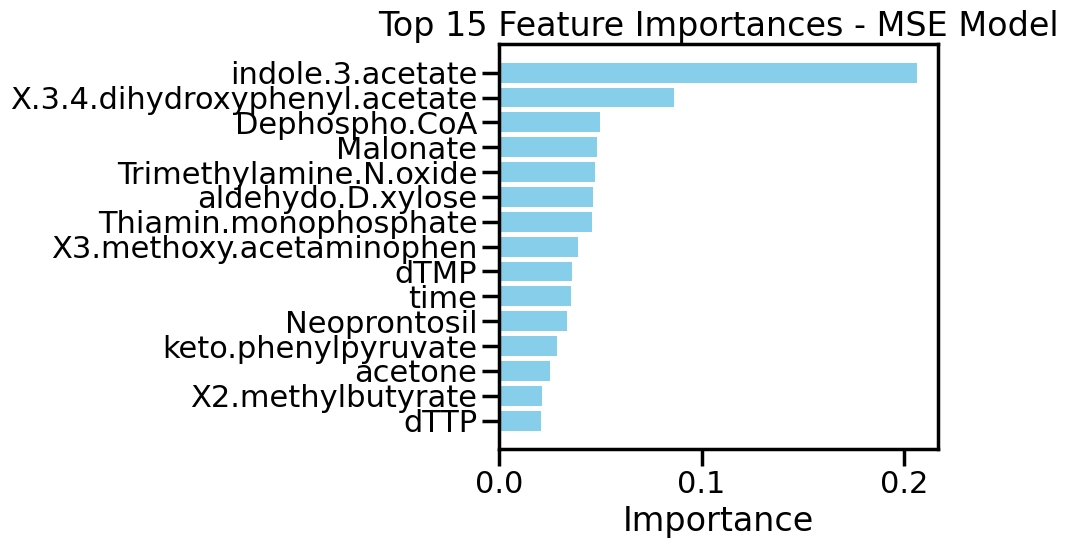

Generating SHAP beeswarm plot for MSE Model...
[OK] SHAP beeswarm saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/shap_beeswarm_only_micom_MSE_Model.png
[OK] SHAP long-format CSV saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/shap_long_only_micom_MSE_Model.csv
SHAP beeswarm plot saved for MSE Model
---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:900: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
INFO     [merf.py:307] Training GLL is 146.95236803439076 at iteration 1.
INFO     [merf.py:307] Training GLL is 157.21483520719818 at iteration 2.
INFO     [merf.py:307] Training GLL is 160.0727853074147 at iteration 3.
INFO     [merf.py:307] Training GLL is 157.2573685798107 at iteration 4.
INFO     [merf.py:307] Training GLL is 155.21193481226513 at iteration 5.
INFO     [merf.py:307] Training GLL is 149.91846663601223 at iteration 6.
INFO     [merf.py:307] Training GLL is 145.2664793044627 at iteration 7.


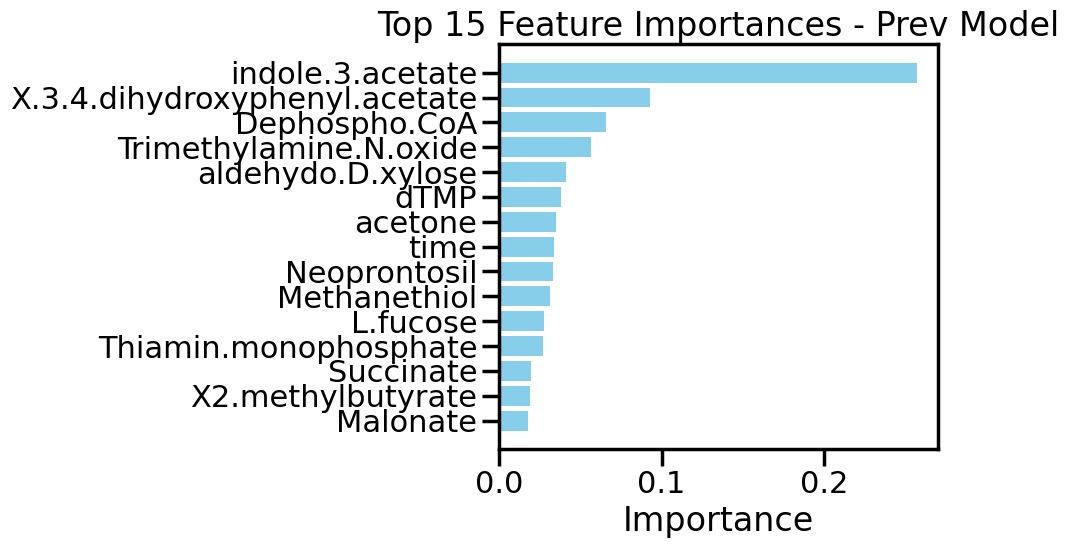

Generating SHAP beeswarm plot for Prev Model...


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 40.997080479171075 at iteration 1.
INFO     [merf.py:307] Training GLL is 69.66419790461013 at iteration 2.


[OK] SHAP beeswarm saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/shap_beeswarm_only_micom_Prev_Model.png
[OK] SHAP long-format CSV saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/shap_long_only_micom_Prev_Model.csv
SHAP beeswarm plot saved for Prev Model
---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


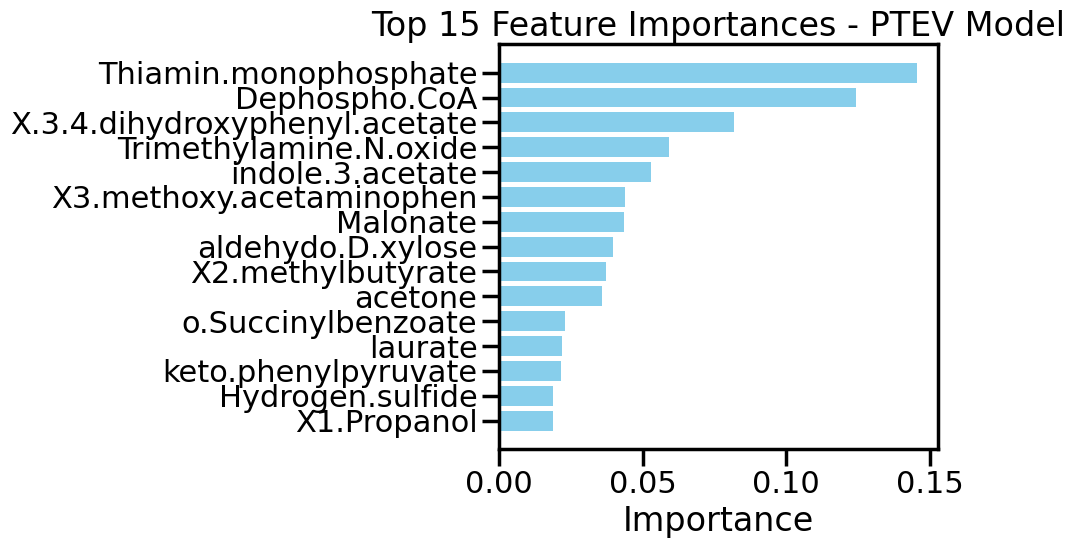

Generating SHAP beeswarm plot for PTEV Model...
[OK] SHAP beeswarm saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/shap_beeswarm_only_micom_PTEV_Model.png
[OK] SHAP long-format CSV saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/shap_long_only_micom_PTEV_Model.csv
SHAP beeswarm plot saved for PTEV Model
---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 138.31075986461067 at iteration 1.
INFO     [merf.py:307] Training GLL is 157.4840062296163 at iteration 2.


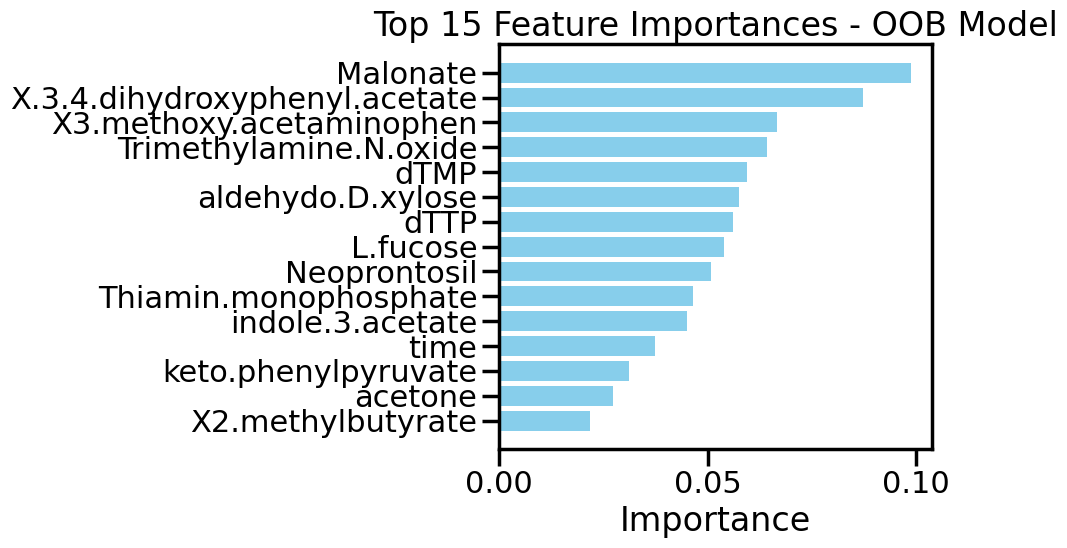

Generating SHAP beeswarm plot for OOB Model...
[OK] SHAP beeswarm saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/shap_beeswarm_only_micom_OOB_Model.png
[OK] SHAP long-format CSV saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/shap_long_only_micom_OOB_Model.csv
SHAP beeswarm plot saved for OOB Model


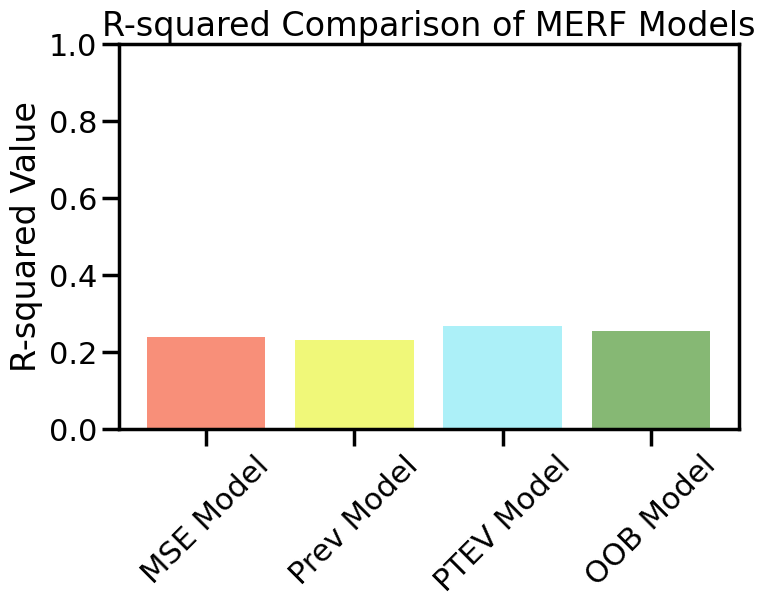

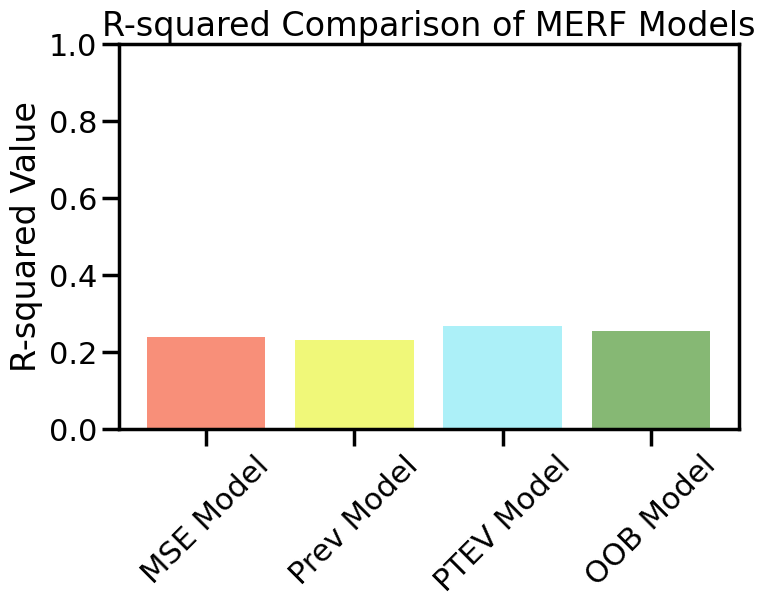

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 37.47140792324356 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 74.10816342139078 at iteration 2.


Best model: PTEV Model with R-squared: 0.2664
Generating detailed SHAP analysis for best model: PTEV Model
[OK] SHAP beeswarm saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/shap_beeswarm_only_micom_BEST_PTEV_Model.png
[OK] SHAP long-format CSV saved: /Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/shap_long_only_micom_BEST_PTEV_Model.csv
Best model SHAP analysis completed for PTEV Model
R-squared values: {'MSE Model': 0.23806301308473177, 'Prev Model': 0.2308484481848294, 'PTEV Model': 0.2663854600785922, 'OOB Model': 0.25481358631409057}
Results DataFrame:
          Model  y_hat_new  R_squared  \
0    MSE Model  -2.713647   0.238063   
1    MSE Model  -2.053328   0.238063   
2    MSE Model  -3.005859   0.238063   
3    MSE Model  -2.149147   0.238063   
4    MSE Model  -1.944391   0.238063   
..         ...        ...  

In [ ]:
column_sets = {
    #"basic": basic,
    #"meta_keep": meta_keep,
    #"only_grs": only_grs, 
    "only_taxa": only_taxa,
    "only_micom": only_micom,
    #"only_pathway": only_pathway,
    #"only_metabo": only_metabo,
    #"only_all": all_col
}

for key, columns in column_sets.items():
    print(f"\n=== Processing column set: {key} ===")
    DATA = delta[columns]
    print(f"Subset for {key} created with shape: {DATA.shape}")

    OUT = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/{key}_delta.csv"
    output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/delta/"
    r2_out = f"{key}_delta_r2.pdf"
    r2_adj_out = f"{key}_delta_r2_adj.pdf"
    feature_imp_out = f"{key}_delta_ft_imp.pdf"
    results_filename = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/{key}_delta_april29.csv"

    # Train/test split
    train_set = DATA[DATA[ID_VAR].isin(train_names)]
    test_set = DATA[DATA[ID_VAR].isin(test_names)]

    clusters_train = pd.Series(train_set[ID_VAR])
    clusters_test = pd.Series(test_set[ID_VAR])

    print("---------- Select predictors for training set ----------")
    X = train_set.drop([BMI_VAR, ID_VAR], axis=1)
    Y = train_set[BMI_VAR].to_numpy()
    Z = np.ones((train_set.shape[0], 1))

    print(f"Length of X: {len(X)}, Length of clusters_train: {len(clusters_train)}, Length of Y: {len(Y)}")
    assert len(X) == len(clusters_train)
    assert len(X) == len(Y)
    print("Final columns after drop:", X.columns.to_list())

    print("---------- Select predictors for test set ----------")
    X_new = test_set.drop([BMI_VAR, ID_VAR], axis=1)
    X_new = X_new[X.columns]  # align with training set columns
    X_new = X_new.astype(X.dtypes)
    Y_new = test_set[BMI_VAR].to_numpy()
    clusters_new = pd.Series(test_set[ID_VAR])
    Z_new = np.ones((len(X_new), 1))
    time_new = test_set[TIME_VAR].astype(float).to_numpy()

    # Hyperparameters
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [None],
        'min_samples_split': [0.05, 0.1, 0.15],
        'max_iter': [2, 10],
        'n_splits': [3, 5, 10]
    }

    y = train_set[[BMI_VAR]][BMI_VAR].to_numpy()
    clusters = train_set[ID_VAR].to_numpy()
    z = np.ones((train_set.shape[0], 1))

    best_score = float('inf')
    best_params = {}
    results = []

    total_combinations = len(list(itertools.product(*param_grid.values())))
    for idx, params in enumerate(itertools.product(*param_grid.values())):
        n_estimators, max_depth, min_samples_split, max_iter, n_splits = params
        print(f"Combination: {params}")
        print(f"Progress: {(idx + 1) / total_combinations * 100:.2f}%")

        scores, prev, ptev, oob_scores = [], [], [], []
        kf = KFold(n_splits=n_splits)

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clusters_train_cv = clusters[train_index]
            clusters_test_cv = pd.Series(clusters[test_index])
            z_train, z_test = z[train_index], z[test_index]

            model = MERF(
                fixed_effects_model=RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    n_jobs=1,
                    oob_score=True
                ),
                gll_early_stop_threshold=None,
                max_iterations=max_iter
            )

            model.fit(X_train.select_dtypes(include=[np.number]), z_train, pd.Series(clusters_train_cv), y_train)
            y_pred = model.predict(X_test, z_test, clusters_test_cv)
            mse = np.mean((y_pred - y_test) ** 2)
            scores.append(mse)

            total_variance = np.var(y_test)
            random_effect_variance = np.var(y_test - y_pred)
            fixed_effect_variance = total_variance - random_effect_variance

            ptev.append(fixed_effect_variance / total_variance if total_variance > 0 else 0)
            prev.append(random_effect_variance / total_variance if total_variance > 0 else 0)

            forest = model.trained_fe_model
            oob_score = round(forest.oob_score_ * 100, 1)
            oob_scores.append(oob_score)

            print(f"ptev: {np.mean(ptev):.4f}, prev: {np.mean(prev):.4f}, OOB Score: {oob_score:.4f}")

        mean_score = np.mean(scores)
        if mean_score < best_score:
            best_score = mean_score
            best_params = params

        results.append({
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'max_iter': max_iter,
            'n_splits': n_splits,
            'mean_mse_score': mean_score,
            'mean_prev': np.mean(prev),
            'mean_ptev': np.mean(ptev),
            'oob_score': np.mean(oob_scores)
        })

    print("Best parameters:", best_params)
    print("Best score:", best_score)

    results_df = pd.DataFrame(results)
    results_df.to_csv(OUT, index=False)

    print("---------- Run MERF models ----------")
    r2_values, results_df = run_merf_analysis2(
        X, Y, Z, clusters,
        X_new, Y_new, Z_new, clusters_new,
        results_df,
        output_dir, r2_out, r2_adj_out, 
        feature_imp_out, results_filename, time_new, include_shap=True, key=key
    )

    print("R-squared values:", r2_values)
    print("Results DataFrame:\n", results_df)
    print(f"---------- Done saving Merf output for {key} ----------\n")


In [ ]:
column_sets = {
    "basic": basic,
    "meta_keep": meta_keep,
    "only_grs": only_grs, 
    "only_taxa": only_taxa,
    "only_micom": only_micom,
    "only_pathway": only_pathway,
    "only_metabo" : only_metabo,
    "only_all" : all_col
}

for key, columns in column_sets.items():
    DATA = delta[columns]
    print(f"Subset for {key} created with shape: {DATA.shape}")
    
    OUT = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/{key}_delta.csv"
    output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/"
    r2_out =  f"{key}_delta_r2.pdf"
    r2_adj_out = f"{key}_delta_r2_adj.pdf"
    feature_imp_out = f"{key}_delta_ft_imp.pdf"
    results_filename = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/{key}_delta_april29.csv"

    # Create train and test sets for the current subset
train_set = DATA[DATA[ID_VAR].isin(train_names)]  # Select rows where ID_VAR is in train_names
test_set = DATA[DATA[ID_VAR].isin(test_names)]    # Select rows where ID_VAR is in test_names

# Ensure clusters_train and clusters_test are pandas Series
clusters_train = pd.Series(train_set[ID_VAR])  # Convert to pandas Series
clusters_test = pd.Series(test_set[ID_VAR])    # Convert to pandas Series

# Proceed with MERF analysis for the current subset
print("---------- Select predictors for training set ----------")
X = train_set.drop([BMI_VAR, ID_VAR], axis=1)
Y = train_set[BMI_VAR].to_numpy()  # Convert Y to numeric array
Z = np.ones((train_set.shape[0], 1))  # Create random effects matrix with ones

# Check lengths before fitting
print(f"Length of X: {len(X)}, Length of clusters_train: {len(clusters_train)}, Length of Y: {len(Y)}")
assert len(X) == len(clusters_train), "Length of X does not match length of clusters_train"
assert len(X) == len(Y), "Length of X does not match length of Y"
print("Final columns after drop:", X.columns.to_list())
print("X train values:", train_set[BMI_VAR])

print("---------- Select predictors for test set ----------")
X_new = test_set.drop([BMI_VAR, ID_VAR], axis=1)
X_new = X_new[X.columns]  # Reorder and select columns to match training set
X_new = X_new.astype(X.dtypes)  # Ensure data types match
Y_new = test_set[BMI_VAR].to_numpy()  # Convert Y to numeric array
clusters_new = pd.Series(test_set[ID_VAR])  # Convert to pandas Series
Z_new = np.ones((len(X_new), 1))  # Create random effects matrix with ones
time_new = test_set[TIME_VAR].astype(float).to_numpy()  # Convert time values to numeric arrayo numeric array

# Hyperparameters to tune
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None],
    'min_samples_split': [0.05, 0.1, 0.15],
    'max_iter': [2, 10],
    'n_splits': [3, 5, 10] #cross-validation
}
# Create training features
# X = train_set.drop(columns=columns_to_drop, errors='ignore')
y = train_set[[BMI_VAR]]
y = y[BMI_VAR].to_numpy() # Convert Y to numeric array
clusters = train_set[ID_VAR].to_numpy() # Get ID variables
z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones

best_score = float('inf')
best_params = {}
results = []  # Initialize a list to store the results of each iteration

# Loop through all possible combinations of parameters
total_combinations = len(list(itertools.product(*param_grid.values())))  # Calculate total combinations
for idx, params in enumerate(itertools.product(*param_grid.values())):
    n_estimators, max_depth, min_samples_split, max_iter, n_splits = params
    
    # Print progress
    progress_percentage = (idx + 1) / total_combinations * 100
    print(f"Combination: {params}\n")
    print(f"Progress: {progress_percentage:.2f}% completed\n")
    scores, prev, ptev, oob_scores = [], [], [], []  # Initialize lists for scores

    # K-fold cross-validation with variable n_splits
    kf = KFold(n_splits=n_splits)
    for train_index, test_index in kf.split(X):
        #print("Train indices:", train_index)
        #print("Test indices:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Use .iloc for row selection
        y_train, y_test = y[train_index], y[test_index]
        clusters_train, clusters_test = clusters[train_index], pd.Series(clusters[test_index])
        z_train, z_test = z[train_index], z[test_index]

        print("Length of clusters_train:", len(clusters_train))
        print("Length of clusters_test:", len(clusters_test))
        #print("Train indices:", train_index)
        #print("Test indices:", test_index)

        model = MERF(
                # Specify the fixed effects model as a Random Forest Regressor
            fixed_effects_model=RandomForestRegressor(
                n_estimators=n_estimators,  # Number of trees in the forest
                max_depth=max_depth,  # Maximum depth of each tree
                min_samples_split=min_samples_split,  # Minimum samples required to split an internal node
                n_jobs=1,  # Number of jobs to run in parallel
                oob_score=True  # Whether to use out-of-bag samples to estimate the R^2 on unseen data
                ),
                # Generalized Linear Model (GLM) early stopping threshold
            gll_early_stop_threshold=None,  # No early stopping threshold set
                # Maximum number of iterations for the MERF algorithm
            max_iterations=max_iter  # Maximum number of iterations to run the MERF algorithm
            )
        model.fit(X_train.select_dtypes(include=[np.number]), z_train, pd.Series(clusters_train), y_train)
        y_pred = model.predict(X_test, z_test, clusters_test)
        scores.append(np.mean((y_pred - y_test) ** 2)) # MSE
        
        # Calculate ptev and prev
        total_variance = np.var(y_test)
        random_effect_variance = np.var(y_test - y_pred)
        fixed_effect_variance = total_variance - random_effect_variance

        ptev.append(np.mean(fixed_effect_variance / total_variance if total_variance > 0 else 0))
        prev.append(np.mean(random_effect_variance / total_variance if total_variance > 0 else 0))

        # Calculate OOB score
        forest = model.trained_fe_model
        oob_score = round(forest.oob_score_ * 100, 1)  # percent variation
        oob_scores.append(oob_score)

        # Print ptev, prev, and OOB score for the current iteration
        print(f"Combination, ptev: {np.mean(ptev):.4f}, prev: {np.mean(prev):.4f}, OOB Score: {oob_score:.4f}")

    # Calculate the mean of the scores for the current combination of parameters
    mean_score = np.mean(scores)
    if mean_score < best_score:
        best_score = mean_score
        best_params = params

    # Append the results of the current iteration to the results list
    result_dict = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'max_iter': max_iter,
        'n_splits': n_splits,
        'mean_mse_score': mean_score,
        'mean_prev': np.mean(prev),
        'mean_ptev': np.mean(ptev),
        'oob_score': np.mean(oob_scores)
    }
    results.append(result_dict)

print("Best parameters:", best_params)
print("Best score:", best_score)

# Convert the results list to a DataFrame and save it to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv(OUT, index=False)

print("---------- Run MERF models ----------")
r2_values, results_df = run_merf_analysis2(
    X, Y, Z, clusters,
    X_new, Y_new, Z_new, clusters_new,
    results_df,
    output_dir, r2_out, r2_adj_out, 
    feature_imp_out, results_filename, time_new, include_shap=True, key=key)

# Print the R-squared values and the results DataFrame
print("R-squared values:", r2_values)
print("Results DataFrame:\n", results_df)
print("---------- Done saving Merf output ----------")
